In [1]:
from sys import path
path.append('../src/')

import os
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
import pickle as pkl
import random as rn
import tensorflow as tf

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, GlobalAvgPool2D
from keras.models import Model, load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight

from global_config import FILE_DUMP_IMAGES, FILE_DUMP_MRKS, FOLDER_MODELS 
from global_config import RANDOM_SEED, IMAGE_SIZE, USER_IDS
from utils import load, plot
from custom_losses import precision, recall, f1, specificity 
from custom_losses import negative_predictive_value as npv 
from custom_losses import matthews_correlation_coefficient as mcc

%matplotlib inline

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\util\nest.py:823: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  _pywrap_tensorflow.RegisterType("Mapping", _collections.Mapping)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\data_structures.py:312: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ListWrapper(List, collections.MutableSequence,
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\util.py:448: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ObjectIdentitySet(collections.MutableSet):
Using Te

In [2]:
print(FILE_DUMP_IMAGES)
print(FILE_DUMP_MRKS)
print(FOLDER_MODELS)
print(IMAGE_SIZE)
print(RANDOM_SEED)
print(USER_IDS)

../data/pybossa/pybossa_images.pkl
../data/pybossa/pybossa_mrks.pkl
../models/autoencoders_requirements/
(224, 224)
42
2_3_5


In [3]:
TEST_SIZE = 0.2

MLFLOW_EXPERIMENT_NAME = 'Autoencoder Requirements'

FILE_BASE_MODEL = '../models/autoencoders_unsupervised/model_2020_03_15-10_43_27.h5'
FILE_MERGED_MODEL = f'{FOLDER_MODELS}merged_model_{USER_IDS}.h5'

In [4]:
def timestamp_model_name(prefix='model_', suffix='', format='%Y_%m_%d-%H_%M_%S', ext='.h5'):
    from datetime import datetime
    timestamp = datetime.now().strftime(format)
    return f'{prefix}{timestamp}{suffix}{ext}'

def set_random_seeds():
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    rn.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)
    
def plot_metrics(y_true, y_pred, hist):
    conf_matrix = confusion_matrix(y_true, y_pred) 
    tn, fp, fn, tp = conf_matrix.ravel()
    
    accuracy_sk = accuracy_score(y_true, y_pred)
    precision_sk = precision_score(y_true, y_pred)
    recall_sk = recall_score(y_true, y_pred)
    f_measure = f1_score(y_true, y_pred)
    specificity_sk = tn / (tn + fp + 1e-7)
    npv_sk = tn / (tn + fn + 1e-7)
    
    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    mcc_sk = num / np.sqrt(den + 1e-7)
    
    print()
    print('   Final Accuracy: {:=6.2f}%'.format(accuracy_sk * 100))
    print('  Final Precision: {:=6.2f}%'.format(precision_sk * 100))
    print('     Final Recall: {:=6.2f}%'.format(recall_sk * 100))
    print('  Final F-measure: {:=6.2f}%'.format(f_measure * 100))
    print('Final Specificity: {:=6.2f}%'.format(specificity_sk * 100))
    print('        Final NPV: {:=6.2f}%'.format(npv_sk * 100))
    print('        Final MCC: {:=6.2f}%'.format(mcc_sk * 100))    

    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    plot.keras_hist(hist.history)

In [5]:
def build_model(base_model, name):
    set_random_seeds()

    outputs = Dense(units=64, activation='relu', name=f'{name}_1')(base_model.output)
    outputs = Dense(units=32, activation='relu', name=f'{name}_2')(outputs)
    outputs = Dense(units=1, activation='sigmoid', name=f'{name}')(outputs)
    model = Model(inputs=base_model.inputs, outputs=outputs)

    for layer in model.layers:
        layer.trainable = (name in layer.name)

    model.compile(
        optimizer='adam', 
        loss='binary_crossentropy', 
        metrics=['accuracy', precision, recall, f1, specificity, npv, mcc]
    )
    return model


def train_model(model, x_train, y_train, x_val, y_val, name):
    FILE_MODEL = FOLDER_MODELS + timestamp_model_name(prefix=f'{name}_')
    metric_to_monitor = 'val_matthews_correlation_coefficient'
    
    list_callbacks = [
        EarlyStopping(monitor=metric_to_monitor, mode='max', patience=30, verbose=1, restore_best_weights=True),
        ModelCheckpoint(FILE_MODEL, monitor=metric_to_monitor, mode='max', verbose=1, save_best_only=True)
    ]
    
    classes = np.unique(y_train)
    weights = compute_class_weight('balanced', classes, y_train)
    class_weights = dict(zip(classes, weights))
    u_train, c_train = np.unique(y_train, return_counts=True)
    u_val, c_val = np.unique(y_val, return_counts=True)
    
    mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
    mlflow.log_param("test_size", TEST_SIZE)
    mlflow.log_param("seed", RANDOM_SEED)
    mlflow.log_param("class_train", dict(zip(u_train, c_train)))
    mlflow.log_param("class_val", dict(zip(u_val, c_val)))
    mlflow.log_param("class_train_prop", dict(zip(u_train, c_train / c_train.sum())))
    mlflow.log_param("class_val_prop", dict(zip(u_val, c_val / c_val.sum())))
    mlflow.set_tag("requirement", name)
    mlflow.set_tag("user_ids", USER_IDS)
    mlflow.keras.autolog()

    hist = model.fit(
        x_train / 255, 
        y_train, 
        batch_size=32, 
        epochs=100, 
        validation_data=(x_val / 255, y_val),
        class_weight=class_weights,
        callbacks=list_callbacks
    )
    mlflow.end_run()
    
    return hist, FILE_MODEL


def train_requirement_branch(base_model, x, y, name):
    classes, counts = np.unique(y, return_counts=True) 
    if len(classes) == 1:
        print(f"the requirement {name} has only one label.")
        return None
    
    if min(counts) == 1:
        print(f"the requirement {name} has only one sample for one of the classes.")
        return None

    x_train, x_val, y_train, y_val = train_test_split(
        x, y, 
        test_size=TEST_SIZE, 
        stratify=y, 
        random_state=RANDOM_SEED
    )

    model = build_model(base_model, name)
    hist, file_model = train_model(model, x_train, y_train, x_val, y_val, name)
    
    y_pred = model.predict(x_val / 255)
    y_pred = np.where(y_pred > 0.5, 1, 0)
    plot_metrics(y_val, y_pred, hist)

    return file_model

# Load Autoencoder 

In [6]:
model = load_model(FILE_BASE_MODEL)

embeddings = GlobalAvgPool2D(name='embeddings')(model.get_layer(name='encoded').output)

encoder = Model(inputs=model.inputs, outputs=embeddings)
encoder.summary()

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Instructions for updating:
Use tf.cast instead.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 224, 224, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 224, 224, 16)      64        
_________________________________________________________________
relu_1 (Activation)          (None, 224, 224, 16)      0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 112, 112, 16)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 112, 112, 32)      4640      
_________________________________________________________________
bn_2 (Batch

# Requirements Training

In [7]:
x, _ = pkl.load(open(FILE_DUMP_IMAGES, 'rb'))
mrks, _ = pkl.load(open(FILE_DUMP_MRKS, 'rb'))

print(x.shape, x.dtype)
print(mrks.shape, mrks.dtype)

list_model_files = []

(5763, 224, 224, 3) float32
(5763,) object


#### 2. Blurred

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.5498 - accuracy: 0.6655 - precision: 0.9512 - recall: 0.6607 - f1: 0.7659 - specificity: 0.6939 - negative_predictive_value: 0.2140 - matthews_correlation_coefficient: 0.2418 - val_loss: 0.4810 - val_accuracy: 0.7632 - val_precision: 0.9417 - val_recall: 0.7398 - val_f1: 0.8262 - val_specificity: 0.7812 - val_negative_predictive_value: 0.3134 - val_matthews_correlation_coefficient: 0.3581

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.35805, saving model to ../models/autoencoders_requirements/blurred_2020_03_25-19_09_24.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4871 - accuracy: 0.6863 - precision: 0.9694 - recall: 0.6700 - f1: 0.7838 - specificity: 0.8284 - negative_predictive_value: 0.2526 - matthews_correlation_coefficient: 0.3287 - val_loss: 0.5145 - val_accuracy: 0.6288 - val_precision: 0.


Epoch 00015: val_matthews_correlation_coefficient improved from 0.35805 to 0.37051, saving model to ../models/autoencoders_requirements/blurred_2020_03_25-19_09_24.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4358 - accuracy: 0.7373 - precision: 0.9739 - recall: 0.7268 - f1: 0.8291 - specificity: 0.8314 - negative_predictive_value: 0.2753 - matthews_correlation_coefficient: 0.3646 - val_loss: 0.4148 - val_accuracy: 0.7598 - val_precision: 0.9460 - val_recall: 0.7317 - val_f1: 0.8224 - val_specificity: 0.7857 - val_negative_predictive_value: 0.3018 - val_matthews_correlation_coefficient: 0.3516

Epoch 00016: val_matthews_correlation_coefficient did not improve from 0.37051
Epoch 17/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4395 - accuracy: 0.7232 - precision: 0.9792 - recall: 0.7072 - f1: 0.8151 - specificity: 0.8442 - negative_predictive_value: 0.2740 - matthews_correlation_coefficient: 0.3675 - val_loss: 0.3283 - val_

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4069 - accuracy: 0.7649 - precision: 0.9778 - recall: 0.7526 - f1: 0.8465 - specificity: 0.8296 - negative_predictive_value: 0.3065 - matthews_correlation_coefficient: 0.4033 - val_loss: 0.3754 - val_accuracy: 0.8135 - val_precision: 0.9442 - val_recall: 0.7949 - val_f1: 0.8615 - val_specificity: 0.7399 - val_negative_predictive_value: 0.3280 - val_matthews_correlation_coefficient: 0.4030

Epoch 00030: val_matthews_correlation_coefficient improved from 0.39208 to 0.40298, saving model to ../models/autoencoders_requirements/blurred_2020_03_25-19_09_24.h5
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3994 - accuracy: 0.7879 - precision: 0.9793 - recall: 0.7789 - f1: 0.8644 - specificity: 0.8406 - negative_predictive_value: 0.3270 - matthews_correlation_coefficient: 0.4280 - val_loss: 0.3828 - val_accuracy: 0.7884 - val_precision: 0.9432 - val_recall: 0.7662 - val_f1: 0.8436 - val_specific

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3897 - accuracy: 0.7718 - precision: 0.9720 - recall: 0.7554 - f1: 0.8468 - specificity: 0.8225 - negative_predictive_value: 0.3062 - matthews_correlation_coefficient: 0.3978 - val_loss: 0.4292 - val_accuracy: 0.7823 - val_precision: 0.9576 - val_recall: 0.7470 - val_f1: 0.8365 - val_specificity: 0.8785 - val_negative_predictive_value: 0.3360 - val_matthews_correlation_coefficient: 0.4209

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.42919
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4176 - accuracy: 0.7282 - precision: 0.9844 - recall: 0.7091 - f1: 0.8116 - specificity: 0.8796 - negative_predictive_value: 0.2973 - matthews_correlation_coefficient: 0.4024 - val_loss: 0.3627 - val_accuracy: 0.8118 - val_precision: 0.9430 - val_recall: 0.7945 - val_f1: 0.8605 - val_specificity: 0.7350 - val_negative_predictive_value: 0.3314 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3647 - accuracy: 0.7998 - precision: 0.9846 - recall: 0.7896 - f1: 0.8736 - specificity: 0.8677 - negative_predictive_value: 0.3427 - matthews_correlation_coefficient: 0.4552 - val_loss: 0.3433 - val_accuracy: 0.8378 - val_precision: 0.9425 - val_recall: 0.8220 - val_f1: 0.8765 - val_specificity: 0.7401 - val_negative_predictive_value: 0.3915 - val_matthews_correlation_coefficient: 0.4265

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.42919
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3759 - accuracy: 0.7889 - precision: 0.9814 - recall: 0.7798 - f1: 0.8666 - specificity: 0.8593 - negative_predictive_value: 0.3330 - matthews_correlation_coefficient: 0.4424 - val_loss: 0.3646 - val_accuracy: 0.8187 - val_precision: 0.9530 - val_recall: 0.7924 - val_f1: 0.8629 - val_specificity: 0.8481 - val_negative_predictive_value: 0.3847 - val_matthews_correlation_coefficie


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.46974
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3515 - accuracy: 0.8056 - precision: 0.9820 - recall: 0.7942 - f1: 0.8755 - specificity: 0.8330 - negative_predictive_value: 0.3430 - matthews_correlation_coefficient: 0.4502 - val_loss: 0.3415 - val_accuracy: 0.8291 - val_precision: 0.9486 - val_recall: 0.8077 - val_f1: 0.8706 - val_specificity: 0.8057 - val_negative_predictive_value: 0.3916 - val_matthews_correlation_coefficient: 0.4475

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.46974
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3530 - accuracy: 0.8056 - precision: 0.9822 - recall: 0.7944 - f1: 0.8759 - specificity: 0.8586 - negative_predictive_value: 0.3478 - matthews_correlation_coefficient: 0.4592 - val_loss: 0.3115 - val_accuracy: 0.8517 - val_precision: 0.9441 - val_recall: 0.8365 - val_f1: 0.8858 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3523 - accuracy: 0.8117 - precision: 0.9820 - recall: 0.8045 - f1: 0.8819 - specificity: 0.8496 - negative_predictive_value: 0.3576 - matthews_correlation_coefficient: 0.4649 - val_loss: 0.3334 - val_accuracy: 0.8586 - val_precision: 0.9468 - val_recall: 0.8429 - val_f1: 0.8904 - val_specificity: 0.8060 - val_negative_predictive_value: 0.4347 - val_matthews_correlation_coefficient: 0.4865

Epoch 00088: val_matthews_correlation_coefficient improved from 0.48310 to 0.48654, saving model to ../models/autoencoders_requirements/blurred_2020_03_25-19_09_24.h5
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3437 - accuracy: 0.8102 - precision: 0.9826 - recall: 0.8026 - f1: 0.8814 - specificity: 0.8636 - negative_predictive_value: 0.3571 - matthews_correlation_coefficient: 0.4674 - val_loss: 0.4098 - val_accuracy: 0.8274 - val_precision: 0.9466 - val_recall: 0.8076 - val_f1: 0.8696 - val_specific

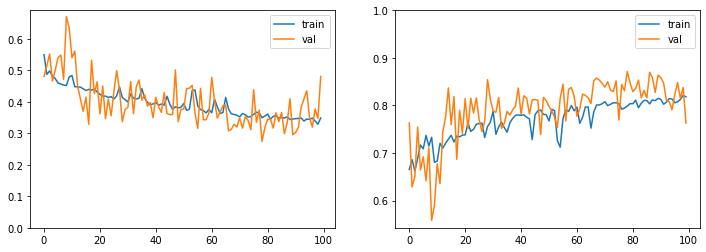

In [8]:
y = np.array([mrk.photo_reqs.blurred.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'blurred')
list_model_files.append(model_file)

#### 3. Looking Away

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6667 - accuracy: 0.5944 - precision: 0.7853 - recall: 0.5700 - f1: 0.6428 - specificity: 0.6411 - negative_predictive_value: 0.4063 - matthews_correlation_coefficient: 0.2066 - val_loss: 0.6432 - val_accuracy: 0.6618 - val_precision: 0.7725 - val_recall: 0.6735 - val_f1: 0.7149 - val_specificity: 0.5737 - val_negative_predictive_value: 0.4432 - val_matthews_correlation_coefficient: 0.2573

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.25729, saving model to ../models/autoencoders_requirements/looking_away_2020_03_25-19_24_09.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6580 - accuracy: 0.6117 - precision: 0.7854 - recall: 0.6034 - f1: 0.6693 - specificity: 0.6279 - negative_predictive_value: 0.4213 - matthews_correlation_coefficient: 0.2177 - val_loss: 0.6716 - val_accuracy: 0.5768 - val_precision

4610/4610 [==============================] - 9s 2ms/step - loss: 0.6181 - accuracy: 0.6651 - precision: 0.8257 - recall: 0.6576 - f1: 0.7240 - specificity: 0.6819 - negative_predictive_value: 0.4712 - matthews_correlation_coefficient: 0.3182 - val_loss: 0.5874 - val_accuracy: 0.6982 - val_precision: 0.8019 - val_recall: 0.6966 - val_f1: 0.7416 - val_specificity: 0.6629 - val_negative_predictive_value: 0.5150 - val_matthews_correlation_coefficient: 0.3368

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.34857
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6106 - accuracy: 0.6824 - precision: 0.8321 - recall: 0.6809 - f1: 0.7422 - specificity: 0.6857 - negative_predictive_value: 0.4923 - matthews_correlation_coefficient: 0.3450 - val_loss: 0.5568 - val_accuracy: 0.7129 - val_precision: 0.7880 - val_recall: 0.7418 - val_f1: 0.7607 - val_specificity: 0.6036 - val_negative_predictive_value: 0.5347 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.38704
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5779 - accuracy: 0.6980 - precision: 0.8326 - recall: 0.7086 - f1: 0.7573 - specificity: 0.6827 - negative_predictive_value: 0.5119 - matthews_correlation_coefficient: 0.3680 - val_loss: 0.5849 - val_accuracy: 0.6817 - val_precision: 0.8353 - val_recall: 0.6319 - val_f1: 0.7152 - val_specificity: 0.7532 - val_negative_predictive_value: 0.4962 - val_matthews_correlation_coefficient: 0.3565

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.38704
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5794 - accuracy: 0.6983 - precision: 0.8472 - recall: 0.6976 - f1: 0.7590 - specificity: 0.7127 - negative_predictive_value: 0.5067 - matthews_correlation_coefficient: 0.3795 - val_loss: 0.5239 - val_accuracy: 0.7398 - val_precision: 0.7958 - val_recall: 0.7788 - val_f1: 0.7842 - val_spe


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.40026
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5637 - accuracy: 0.7015 - precision: 0.8517 - recall: 0.6943 - f1: 0.7571 - specificity: 0.7260 - negative_predictive_value: 0.5214 - matthews_correlation_coefficient: 0.3944 - val_loss: 0.5886 - val_accuracy: 0.6756 - val_precision: 0.8402 - val_recall: 0.6148 - val_f1: 0.7047 - val_specificity: 0.7693 - val_negative_predictive_value: 0.4940 - val_matthews_correlation_coefficient: 0.3576

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.40026
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5537 - accuracy: 0.7119 - precision: 0.8485 - recall: 0.7134 - f1: 0.7708 - specificity: 0.7139 - negative_predictive_value: 0.5266 - matthews_correlation_coefficient: 0.3994 - val_loss: 0.6538 - val_accuracy: 0.6461 - val_precision: 0.8496 - val_recall: 0.5562 - val_f1: 0.6681 - val_spe


Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.40086
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5892 - accuracy: 0.6980 - precision: 0.8389 - recall: 0.6894 - f1: 0.7490 - specificity: 0.7066 - negative_predictive_value: 0.5070 - matthews_correlation_coefficient: 0.3687 - val_loss: 0.7694 - val_accuracy: 0.5794 - val_precision: 0.8707 - val_recall: 0.4263 - val_f1: 0.5671 - val_specificity: 0.8936 - val_negative_predictive_value: 0.4271 - val_matthews_correlation_coefficient: 0.3062

Epoch 00060: val_matthews_correlation_coefficient did not improve from 0.40086
Epoch 61/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5681 - accuracy: 0.7011 - precision: 0.8444 - recall: 0.7029 - f1: 0.7579 - specificity: 0.7019 - negative_predictive_value: 0.5147 - matthews_correlation_coefficient: 0.3819 - val_loss: 0.5504 - val_accuracy: 0.7051 - val_precision: 0.8479 - val_recall: 0.6547 - val_f1: 0.7352 - val_spe


Epoch 00074: val_matthews_correlation_coefficient improved from 0.40086 to 0.40390, saving model to ../models/autoencoders_requirements/looking_away_2020_03_25-19_24_09.h5
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5349 - accuracy: 0.7310 - precision: 0.8583 - recall: 0.7384 - f1: 0.7866 - specificity: 0.7125 - negative_predictive_value: 0.5508 - matthews_correlation_coefficient: 0.4294 - val_loss: 0.6433 - val_accuracy: 0.6487 - val_precision: 0.8718 - val_recall: 0.5406 - val_f1: 0.6618 - val_specificity: 0.8585 - val_negative_predictive_value: 0.4727 - val_matthews_correlation_coefficient: 0.3692

Epoch 00075: val_matthews_correlation_coefficient did not improve from 0.40390
Epoch 76/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5377 - accuracy: 0.7193 - precision: 0.8611 - recall: 0.7144 - f1: 0.7738 - specificity: 0.7311 - negative_predictive_value: 0.5347 - matthews_correlation_coefficient: 0.4202 - val_loss: 0.5979 -

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5265 - accuracy: 0.7278 - precision: 0.8645 - recall: 0.7106 - f1: 0.7737 - specificity: 0.7491 - negative_predictive_value: 0.5398 - matthews_correlation_coefficient: 0.4364 - val_loss: 0.5733 - val_accuracy: 0.6886 - val_precision: 0.8601 - val_recall: 0.6165 - val_f1: 0.7146 - val_specificity: 0.8148 - val_negative_predictive_value: 0.5042 - val_matthews_correlation_coefficient: 0.3953

Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.42497
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5264 - accuracy: 0.7325 - precision: 0.8705 - recall: 0.7268 - f1: 0.7866 - specificity: 0.7504 - negative_predictive_value: 0.5496 - matthews_correlation_coefficient: 0.4461 - val_loss: 0.6185 - val_accuracy: 0.6713 - val_precision: 0.8729 - val_recall: 0.5789 - val_f1: 0.6914 - val_specificity: 0.8475 - val_negative_predictive_value: 0.4902 - val_matthews_correlation_coefficie

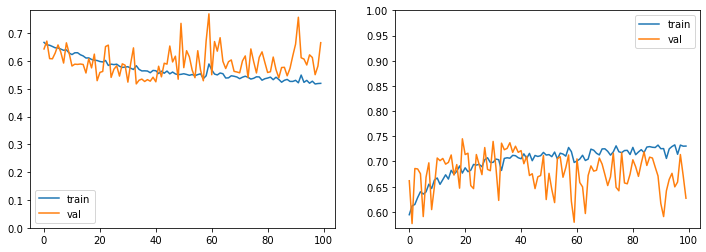

In [9]:
y = np.array([mrk.photo_reqs.looking_away.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'looking_away')
list_model_files.append(model_file)

#### 4. Ink Marked/Creased

In [10]:
y = np.array([mrk.photo_reqs.ink_marked_creased.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'ink_marked_creased')
list_model_files.append(model_file)

the requirement ink_marked_creased has only one label.


#### 5. Unnatural Skin Tone 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6260 - accuracy: 0.6488 - precision: 0.7684 - recall: 0.6540 - f1: 0.6876 - specificity: 0.6397 - negative_predictive_value: 0.5175 - matthews_correlation_coefficient: 0.2915 - val_loss: 0.6978 - val_accuracy: 0.5984 - val_precision: 0.7739 - val_recall: 0.4989 - val_f1: 0.5993 - val_specificity: 0.7354 - val_negative_predictive_value: 0.4477 - val_matthews_correlation_coefficient: 0.2539

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.25393, saving model to ../models/autoencoders_requirements/unnatural_skin_tone_2020_03_25-19_38_51.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5919 - accuracy: 0.6933 - precision: 0.7977 - recall: 0.7087 - f1: 0.7312 - specificity: 0.6722 - negative_predictive_value: 0.5913 - matthews_correlation_coefficient: 0.3841 - val_loss: 0.5897 - val_accuracy: 0.6756 - val_pr

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4852 - accuracy: 0.7716 - precision: 0.8437 - recall: 0.7992 - f1: 0.8150 - specificity: 0.7313 - negative_predictive_value: 0.6716 - matthews_correlation_coefficient: 0.5215 - val_loss: 0.5649 - val_accuracy: 0.7233 - val_precision: 0.8054 - val_recall: 0.7005 - val_f1: 0.7438 - val_specificity: 0.7073 - val_negative_predictive_value: 0.5788 - val_matthews_correlation_coefficient: 0.4221

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.46291
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4865 - accuracy: 0.7714 - precision: 0.8381 - recall: 0.7936 - f1: 0.8088 - specificity: 0.7261 - negative_predictive_value: 0.6669 - matthews_correlation_coefficient: 0.5182 - val_loss: 0.4861 - val_accuracy: 0.7658 - val_precision: 0.7890 - val_recall: 0.8071 - val_f1: 0.7945 - val_specificity: 0.6344 - val_negative_predictive_value: 0.6643 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4482 - accuracy: 0.7861 - precision: 0.8533 - recall: 0.8151 - f1: 0.8293 - specificity: 0.7317 - negative_predictive_value: 0.6759 - matthews_correlation_coefficient: 0.5369 - val_loss: 0.4573 - val_accuracy: 0.7702 - val_precision: 0.7973 - val_recall: 0.8024 - val_f1: 0.7970 - val_specificity: 0.6534 - val_negative_predictive_value: 0.6615 - val_matthews_correlation_coefficient: 0.4833

Epoch 00029: val_matthews_correlation_coefficient improved from 0.48129 to 0.48327, saving model to ../models/autoencoders_requirements/unnatural_skin_tone_2020_03_25-19_38_51.h5
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4401 - accuracy: 0.7965 - precision: 0.8582 - recall: 0.8247 - f1: 0.8381 - specificity: 0.7449 - negative_predictive_value: 0.6924 - matthews_correlation_coefficient: 0.5592 - val_loss: 0.5902 - val_accuracy: 0.7242 - val_precision: 0.8279 - val_recall: 0.6721 - val_f1: 0.7356 - 


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.49823
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4270 - accuracy: 0.8039 - precision: 0.8639 - recall: 0.8290 - f1: 0.8411 - specificity: 0.7564 - negative_predictive_value: 0.7115 - matthews_correlation_coefficient: 0.5810 - val_loss: 0.4594 - val_accuracy: 0.7702 - val_precision: 0.8353 - val_recall: 0.8117 - val_f1: 0.8200 - val_specificity: 0.6753 - val_negative_predictive_value: 0.6455 - val_matthews_correlation_coefficient: 0.4833

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.49823
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4234 - accuracy: 0.8017 - precision: 0.8654 - recall: 0.8226 - f1: 0.8385 - specificity: 0.7613 - negative_predictive_value: 0.7038 - matthews_correlation_coefficient: 0.5774 - val_loss: 0.4528 - val_accuracy: 0.7754 - val_precision: 0.8079 - val_recall: 0.7955 - val_f1: 0.7977 - val_spe


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.51286
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4049 - accuracy: 0.8145 - precision: 0.8795 - recall: 0.8282 - f1: 0.8486 - specificity: 0.7845 - negative_predictive_value: 0.7140 - matthews_correlation_coefficient: 0.6035 - val_loss: 0.4544 - val_accuracy: 0.7788 - val_precision: 0.8454 - val_recall: 0.8136 - val_f1: 0.8260 - val_specificity: 0.7124 - val_negative_predictive_value: 0.6599 - val_matthews_correlation_coefficient: 0.5147

Epoch 00059: val_matthews_correlation_coefficient improved from 0.51286 to 0.51466, saving model to ../models/autoencoders_requirements/unnatural_skin_tone_2020_03_25-19_38_51.h5
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4138 - accuracy: 0.8141 - precision: 0.8691 - recall: 0.8412 - f1: 0.8516 - specificity: 0.7627 - negative_predictive_value: 0.7186 - matthews_correlation_coefficient: 0.5944 - val_loss: 0

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4042 - accuracy: 0.8158 - precision: 0.8804 - recall: 0.8372 - f1: 0.8531 - specificity: 0.7816 - negative_predictive_value: 0.7209 - matthews_correlation_coefficient: 0.6089 - val_loss: 0.4758 - val_accuracy: 0.7728 - val_precision: 0.8180 - val_recall: 0.8404 - val_f1: 0.8263 - val_specificity: 0.6379 - val_negative_predictive_value: 0.6714 - val_matthews_correlation_coefficient: 0.4828

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.52197
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3916 - accuracy: 0.8213 - precision: 0.8753 - recall: 0.8473 - f1: 0.8556 - specificity: 0.7769 - negative_predictive_value: 0.7314 - matthews_correlation_coefficient: 0.6161 - val_loss: 0.4933 - val_accuracy: 0.7502 - val_precision: 0.8381 - val_recall: 0.7072 - val_f1: 0.7637 - val_specificity: 0.7706 - val_negative_predictive_value: 0.5971 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3904 - accuracy: 0.8243 - precision: 0.8714 - recall: 0.8419 - f1: 0.8525 - specificity: 0.7879 - negative_predictive_value: 0.7356 - matthews_correlation_coefficient: 0.6189 - val_loss: 0.4918 - val_accuracy: 0.7641 - val_precision: 0.8707 - val_recall: 0.7519 - val_f1: 0.8025 - val_specificity: 0.7770 - val_negative_predictive_value: 0.6176 - val_matthews_correlation_coefficient: 0.5072

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.55027
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3857 - accuracy: 0.8282 - precision: 0.8848 - recall: 0.8464 - f1: 0.8612 - specificity: 0.7898 - negative_predictive_value: 0.7337 - matthews_correlation_coefficient: 0.6280 - val_loss: 0.4480 - val_accuracy: 0.7745 - val_precision: 0.8319 - val_recall: 0.8235 - val_f1: 0.8254 - val_specificity: 0.6733 - val_negative_predictive_value: 0.6538 - val_matthews_correlation_coefficie

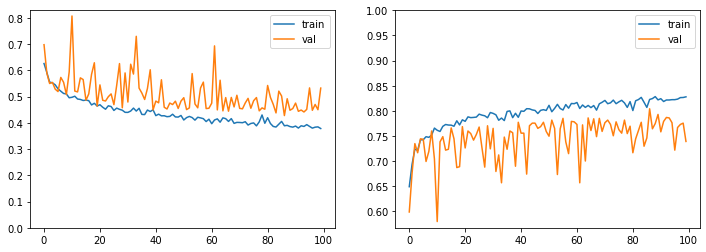

In [11]:
y = np.array([mrk.photo_reqs.unnatural_skin_tone.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'unnatural_skin_tone')
list_model_files.append(model_file)

#### 6. Too Dark/Light 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5893 - accuracy: 0.6831 - precision: 0.9585 - recall: 0.6816 - f1: 0.7738 - specificity: 0.6705 - negative_predictive_value: 0.2036 - matthews_correlation_coefficient: 0.2492 - val_loss: 0.6029 - val_accuracy: 0.6999 - val_precision: 0.9592 - val_recall: 0.6668 - val_f1: 0.7838 - val_specificity: 0.8356 - val_negative_predictive_value: 0.2020 - val_matthews_correlation_coefficient: 0.2787

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.27874, saving model to ../models/autoencoders_requirements/too_dark_light_2020_03_25-19_53_30.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4755 - accuracy: 0.7800 - precision: 0.9832 - recall: 0.7800 - f1: 0.8608 - specificity: 0.7296 - negative_predictive_value: 0.2815 - matthews_correlation_coefficient: 0.3562 - val_loss: 0.4137 - val_accuracy: 0.8187 - val_precisi

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3424 - accuracy: 0.8627 - precision: 0.9871 - recall: 0.8644 - f1: 0.9200 - specificity: 0.8062 - negative_predictive_value: 0.3504 - matthews_correlation_coefficient: 0.4652 - val_loss: 0.3566 - val_accuracy: 0.8543 - val_precision: 0.9589 - val_recall: 0.8326 - val_f1: 0.8903 - val_specificity: 0.7883 - val_negative_predictive_value: 0.3173 - val_matthews_correlation_coefficient: 0.4040

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.46855
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3547 - accuracy: 0.8482 - precision: 0.9875 - recall: 0.8484 - f1: 0.9101 - specificity: 0.7991 - negative_predictive_value: 0.3421 - matthews_correlation_coefficient: 0.4520 - val_loss: 0.4471 - val_accuracy: 0.7918 - val_precision: 0.9607 - val_recall: 0.7631 - val_f1: 0.8493 - val_specificity: 0.8108 - val_negative_predictive_value: 0.2558 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.48564
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3164 - accuracy: 0.8597 - precision: 0.9867 - recall: 0.8616 - f1: 0.9180 - specificity: 0.8206 - negative_predictive_value: 0.3621 - matthews_correlation_coefficient: 0.4769 - val_loss: 0.6667 - val_accuracy: 0.6973 - val_precision: 0.9670 - val_recall: 0.6584 - val_f1: 0.7811 - val_specificity: 0.8559 - val_negative_predictive_value: 0.2063 - val_matthews_correlation_coefficient: 0.2937

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.48564
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3288 - accuracy: 0.8584 - precision: 0.9871 - recall: 0.8566 - f1: 0.9146 - specificity: 0.8085 - negative_predictive_value: 0.3649 - matthews_correlation_coefficient: 0.4747 - val_loss: 0.3944 - val_accuracy: 0.8326 - val_precision: 0.9625 - val_recall: 0.8058 - val_f1: 0.8763 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3198 - accuracy: 0.8599 - precision: 0.9883 - recall: 0.8607 - f1: 0.9170 - specificity: 0.7882 - negative_predictive_value: 0.3640 - matthews_correlation_coefficient: 0.4676 - val_loss: 0.2152 - val_accuracy: 0.9063 - val_precision: 0.9572 - val_recall: 0.8886 - val_f1: 0.9211 - val_specificity: 0.7777 - val_negative_predictive_value: 0.4224 - val_matthews_correlation_coefficient: 0.4947

Epoch 00044: val_matthews_correlation_coefficient improved from 0.48564 to 0.49473, saving model to ../models/autoencoders_requirements/too_dark_light_2020_03_25-19_53_30.h5
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3016 - accuracy: 0.8688 - precision: 0.9871 - recall: 0.8708 - f1: 0.9233 - specificity: 0.8114 - negative_predictive_value: 0.3681 - matthews_correlation_coefficient: 0.4787 - val_loss: 0.2568 - val_accuracy: 0.8951 - val_precision: 0.9572 - val_recall: 0.8773 - val_f1: 0.9148 - val_s


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.50035
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2597 - accuracy: 0.8857 - precision: 0.9899 - recall: 0.8867 - f1: 0.9339 - specificity: 0.8323 - negative_predictive_value: 0.4145 - matthews_correlation_coefficient: 0.5260 - val_loss: 0.6747 - val_accuracy: 0.7008 - val_precision: 0.9667 - val_recall: 0.6622 - val_f1: 0.7832 - val_specificity: 0.8806 - val_negative_predictive_value: 0.2111 - val_matthews_correlation_coefficient: 0.3054

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.50035
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2764 - accuracy: 0.8709 - precision: 0.9900 - recall: 0.8706 - f1: 0.9246 - specificity: 0.8381 - negative_predictive_value: 0.3830 - matthews_correlation_coefficient: 0.5025 - val_loss: 0.5731 - val_accuracy: 0.7441 - val_precision: 0.9646 - val_recall: 0.7094 - val_f1: 0.8161 - val_spe


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.50035
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2482 - accuracy: 0.8931 - precision: 0.9902 - recall: 0.8909 - f1: 0.9363 - specificity: 0.8096 - negative_predictive_value: 0.4211 - matthews_correlation_coefficient: 0.5275 - val_loss: 0.8914 - val_accuracy: 0.6349 - val_precision: 0.9675 - val_recall: 0.5917 - val_f1: 0.7311 - val_specificity: 0.8896 - val_negative_predictive_value: 0.1856 - val_matthews_correlation_coefficient: 0.2670

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.50035
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2646 - accuracy: 0.8846 - precision: 0.9905 - recall: 0.8846 - f1: 0.9332 - specificity: 0.8252 - negative_predictive_value: 0.3942 - matthews_correlation_coefficient: 0.5121 - val_loss: 0.4302 - val_accuracy: 0.8153 - val_precision: 0.9654 - val_recall: 0.7845 - val_f1: 0.8646 - val_spe

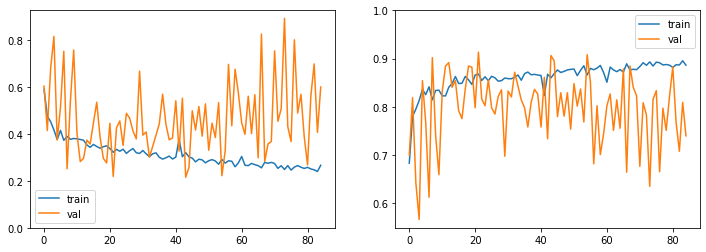

In [12]:
y = np.array([mrk.photo_reqs.too_dark_light.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'too_dark_light')
list_model_files.append(model_file)

#### 7. Washed Out

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5568 - accuracy: 0.8004 - precision: 0.9962 - recall: 0.8039 - f1: 0.8815 - specificity: 0.1276 - negative_predictive_value: 0.0223 - matthews_correlation_coefficient: 0.0418 - val_loss: 0.4339 - val_accuracy: 0.7233 - val_precision: 1.0000 - val_recall: 0.7288 - val_f1: 0.8406 - val_specificity: 0.1892 - val_negative_predictive_value: 0.0292 - val_matthews_correlation_coefficient: 0.0642

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.06416, saving model to ../models/autoencoders_requirements/washed_out_2020_03_25-20_06_02.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4093 - accuracy: 0.7549 - precision: 0.9994 - recall: 0.7548 - f1: 0.8465 - specificity: 0.2103 - negative_predictive_value: 0.0395 - matthews_correlation_coefficient: 0.0763 - val_loss: 0.1021 - val_accuracy: 0.9905 - val_precision: 


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.14860
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.0820 - accuracy: 0.9640 - precision: 1.0000 - recall: 0.9640 - f1: 0.9812 - specificity: 0.2345 - negative_predictive_value: 0.1700 - matthews_correlation_coefficient: 0.1920 - val_loss: 0.0594 - val_accuracy: 0.9801 - val_precision: 0.9992 - val_recall: 0.9813 - val_f1: 0.9900 - val_specificity: 0.1622 - val_negative_predictive_value: 0.1261 - val_matthews_correlation_coefficient: 0.1404

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.14860
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1286 - accuracy: 0.9427 - precision: 0.9996 - recall: 0.9430 - f1: 0.9684 - specificity: 0.2345 - negative_predictive_value: 0.1493 - matthews_correlation_coefficient: 0.1727 - val_loss: 0.0758 - val_accuracy: 0.9748 - val_precision: 0.9992 - val_recall: 0.9762 - val_f1: 0.9874 - val_spe


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.14860
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.0489 - accuracy: 0.9709 - precision: 1.0000 - recall: 0.9710 - f1: 0.9843 - specificity: 0.2414 - negative_predictive_value: 0.1971 - matthews_correlation_coefficient: 0.2123 - val_loss: 0.0311 - val_accuracy: 0.9913 - val_precision: 0.9992 - val_recall: 0.9923 - val_f1: 0.9957 - val_specificity: 0.1622 - val_negative_predictive_value: 0.1532 - val_matthews_correlation_coefficient: 0.1568

Epoch 00030: val_matthews_correlation_coefficient improved from 0.14860 to 0.15683, saving model to ../models/autoencoders_requirements/washed_out_2020_03_25-20_06_02.h5
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.0867 - accuracy: 0.9638 - precision: 0.9995 - recall: 0.9643 - f1: 0.9803 - specificity: 0.2000 - negative_predictive_value: 0.1626 - matthews_correlation_coefficient: 0.1752 - val_loss: 0.0365 - v


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.15683
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.0407 - accuracy: 0.9811 - precision: 1.0000 - recall: 0.9811 - f1: 0.9903 - specificity: 0.2552 - negative_predictive_value: 0.1956 - matthews_correlation_coefficient: 0.2178 - val_loss: 0.0480 - val_accuracy: 0.9844 - val_precision: 0.9992 - val_recall: 0.9856 - val_f1: 0.9922 - val_specificity: 0.1622 - val_negative_predictive_value: 0.1396 - val_matthews_correlation_coefficient: 0.1486

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.15683
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.0525 - accuracy: 0.9757 - precision: 0.9998 - recall: 0.9760 - f1: 0.9873 - specificity: 0.2138 - negative_predictive_value: 0.1738 - matthews_correlation_coefficient: 0.1880 - val_loss: 0.0501 - val_accuracy: 0.9835 - val_precision: 0.9992 - val_recall: 0.9847 - val_f1: 0.9917 - val_spe


Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.15683
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.0336 - accuracy: 0.9833 - precision: 1.0000 - recall: 0.9832 - f1: 0.9914 - specificity: 0.2414 - negative_predictive_value: 0.1790 - matthews_correlation_coefficient: 0.2020 - val_loss: 0.0665 - val_accuracy: 0.9783 - val_precision: 0.9992 - val_recall: 0.9796 - val_f1: 0.9891 - val_specificity: 0.1622 - val_negative_predictive_value: 0.1396 - val_matthews_correlation_coefficient: 0.1486
Restoring model weights from the end of the best epoch

Epoch 00060: val_matthews_correlation_coefficient did not improve from 0.15683
Epoch 00060: early stopping

   Final Accuracy:  99.13%
  Final Precision:  99.91%
     Final Recall:  99.21%
  Final F-measure:  99.56%
Final Specificity:  88.89%
        Final NPV:  47.06%
        Final MCC:  64.33%
[[   8    1]
 [   9 1135]]
              precision    recall  f1-score   support

           0 

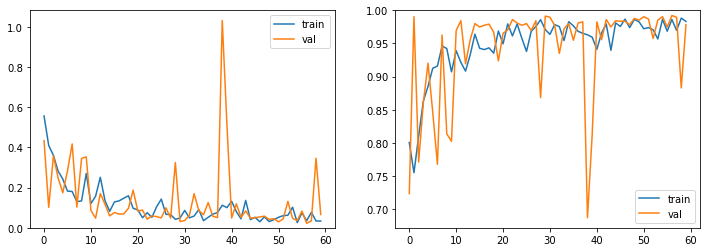

In [13]:
y = np.array([mrk.photo_reqs.washed_out.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'washed_out')
list_model_files.append(model_file)

#### 8. Pixelation

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6615 - accuracy: 0.5848 - precision: 0.9475 - recall: 0.5796 - f1: 0.7006 - specificity: 0.6205 - negative_predictive_value: 0.1104 - matthews_correlation_coefficient: 0.1322 - val_loss: 0.7774 - val_accuracy: 0.4796 - val_precision: 0.9468 - val_recall: 0.4434 - val_f1: 0.5974 - val_specificity: 0.6725 - val_negative_predictive_value: 0.0989 - val_matthews_correlation_coefficient: 0.1185

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.11851, saving model to ../models/autoencoders_requirements/pixelation_2020_03_25-20_15_00.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6352 - accuracy: 0.6388 - precision: 0.9662 - recall: 0.6390 - f1: 0.7586 - specificity: 0.5566 - negative_predictive_value: 0.1193 - matthews_correlation_coefficient: 0.1407 - val_loss: 0.5454 - val_accuracy: 0.6479 - val_precision: 


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.21221
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5465 - accuracy: 0.7048 - precision: 0.9743 - recall: 0.7043 - f1: 0.8131 - specificity: 0.6832 - negative_predictive_value: 0.1594 - matthews_correlation_coefficient: 0.2297 - val_loss: 0.3695 - val_accuracy: 0.8404 - val_precision: 0.9554 - val_recall: 0.8728 - val_f1: 0.9111 - val_specificity: 0.3410 - val_negative_predictive_value: 0.1961 - val_matthews_correlation_coefficient: 0.1787

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.21221
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5354 - accuracy: 0.7189 - precision: 0.9749 - recall: 0.7180 - f1: 0.8227 - specificity: 0.6955 - negative_predictive_value: 0.1661 - matthews_correlation_coefficient: 0.2415 - val_loss: 0.4630 - val_accuracy: 0.7242 - val_precision: 0.9678 - val_recall: 0.7366 - val_f1: 0.8337 - val_spe


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.21221
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5256 - accuracy: 0.7180 - precision: 0.9732 - recall: 0.7156 - f1: 0.8196 - specificity: 0.7002 - negative_predictive_value: 0.1694 - matthews_correlation_coefficient: 0.2475 - val_loss: 0.3954 - val_accuracy: 0.8265 - val_precision: 0.9635 - val_recall: 0.8504 - val_f1: 0.9018 - val_specificity: 0.4419 - val_negative_predictive_value: 0.2075 - val_matthews_correlation_coefficient: 0.2217

Epoch 00030: val_matthews_correlation_coefficient improved from 0.21221 to 0.22169, saving model to ../models/autoencoders_requirements/pixelation_2020_03_25-20_15_00.h5
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5325 - accuracy: 0.7059 - precision: 0.9756 - recall: 0.7050 - f1: 0.8116 - specificity: 0.7076 - negative_predictive_value: 0.1716 - matthews_correlation_coefficient: 0.2473 - val_loss: 0.3304 - v

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5178 - accuracy: 0.7325 - precision: 0.9758 - recall: 0.7329 - f1: 0.8298 - specificity: 0.6461 - negative_predictive_value: 0.1763 - matthews_correlation_coefficient: 0.2431 - val_loss: 0.3017 - val_accuracy: 0.8820 - val_precision: 0.9496 - val_recall: 0.9259 - val_f1: 0.9366 - val_specificity: 0.2401 - val_negative_predictive_value: 0.2252 - val_matthews_correlation_coefficient: 0.1698

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.22255
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5086 - accuracy: 0.7453 - precision: 0.9774 - recall: 0.7456 - f1: 0.8425 - specificity: 0.7126 - negative_predictive_value: 0.1874 - matthews_correlation_coefficient: 0.2720 - val_loss: 0.3824 - val_accuracy: 0.8317 - val_precision: 0.9610 - val_recall: 0.8585 - val_f1: 0.9054 - val_specificity: 0.4378 - val_negative_predictive_value: 0.2053 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4934 - accuracy: 0.7521 - precision: 0.9791 - recall: 0.7482 - f1: 0.8454 - specificity: 0.7429 - negative_predictive_value: 0.1922 - matthews_correlation_coefficient: 0.2895 - val_loss: 0.4173 - val_accuracy: 0.7719 - val_precision: 0.9657 - val_recall: 0.7898 - val_f1: 0.8668 - val_specificity: 0.4878 - val_negative_predictive_value: 0.1612 - val_matthews_correlation_coefficient: 0.1883

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.23137
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4893 - accuracy: 0.7518 - precision: 0.9775 - recall: 0.7524 - f1: 0.8469 - specificity: 0.6882 - negative_predictive_value: 0.1958 - matthews_correlation_coefficient: 0.2726 - val_loss: 0.4465 - val_accuracy: 0.7511 - val_precision: 0.9672 - val_recall: 0.7667 - val_f1: 0.8526 - val_specificity: 0.4991 - val_negative_predictive_value: 0.1569 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4831 - accuracy: 0.7499 - precision: 0.9771 - recall: 0.7477 - f1: 0.8442 - specificity: 0.6819 - negative_predictive_value: 0.1849 - matthews_correlation_coefficient: 0.2655 - val_loss: 0.3445 - val_accuracy: 0.8369 - val_precision: 0.9574 - val_recall: 0.8674 - val_f1: 0.9088 - val_specificity: 0.3680 - val_negative_predictive_value: 0.2021 - val_matthews_correlation_coefficient: 0.1882

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.23137
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4795 - accuracy: 0.7453 - precision: 0.9787 - recall: 0.7452 - f1: 0.8437 - specificity: 0.7023 - negative_predictive_value: 0.1917 - matthews_correlation_coefficient: 0.2749 - val_loss: 0.2587 - val_accuracy: 0.9297 - val_precision: 0.9465 - val_recall: 0.9819 - val_f1: 0.9633 - val_specificity: 0.1775 - val_negative_predictive_value: 0.2793 - val_matthews_correlation_coefficie


Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.23137
Epoch 00088: early stopping

   Final Accuracy:  80.23%
  Final Precision:  96.90%
     Final Recall:  81.38%
  Final F-measure:  88.46%
Final Specificity:  64.56%
        Final NPV:  20.32%
        Final MCC:  28.12%
[[ 51  28]
 [200 874]]
              precision    recall  f1-score   support

           0       0.20      0.65      0.31        79
           1       0.97      0.81      0.88      1074

    accuracy                           0.80      1153
   macro avg       0.59      0.73      0.60      1153
weighted avg       0.92      0.80      0.85      1153



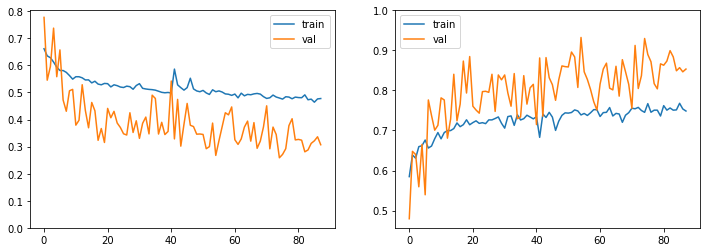

In [14]:
y = np.array([mrk.photo_reqs.pixelation.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'pixelation')
list_model_files.append(model_file)

#### 9. Hair Across Eyes 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5837 - accuracy: 0.6662 - precision: 0.9377 - recall: 0.6395 - f1: 0.7512 - specificity: 0.8005 - negative_predictive_value: 0.3224 - matthews_correlation_coefficient: 0.3341 - val_loss: 0.5787 - val_accuracy: 0.6635 - val_precision: 0.9488 - val_recall: 0.6346 - val_f1: 0.7571 - val_specificity: 0.8183 - val_negative_predictive_value: 0.3135 - val_matthews_correlation_coefficient: 0.3416

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.34161, saving model to ../models/autoencoders_requirements/hair_across_eyes_2020_03_25-20_27_58.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5632 - accuracy: 0.6692 - precision: 0.9464 - recall: 0.6351 - f1: 0.7575 - specificity: 0.8210 - negative_predictive_value: 0.3203 - matthews_correlation_coefficient: 0.3465 - val_loss: 0.5678 - val_accuracy: 0.6626 - val_preci

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5169 - accuracy: 0.7167 - precision: 0.9478 - recall: 0.7004 - f1: 0.7992 - specificity: 0.8103 - negative_predictive_value: 0.3724 - matthews_correlation_coefficient: 0.3993 - val_loss: 0.6056 - val_accuracy: 0.6791 - val_precision: 0.9191 - val_recall: 0.6301 - val_f1: 0.7456 - val_specificity: 0.8116 - val_negative_predictive_value: 0.3235 - val_matthews_correlation_coefficient: 0.3524

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.35610
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5124 - accuracy: 0.7286 - precision: 0.9468 - recall: 0.7138 - f1: 0.8093 - specificity: 0.8149 - negative_predictive_value: 0.3750 - matthews_correlation_coefficient: 0.4077 - val_loss: 0.5821 - val_accuracy: 0.6990 - val_precision: 0.9129 - val_recall: 0.6613 - val_f1: 0.7646 - val_specificity: 0.7726 - val_negative_predictive_value: 0.3343 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.38482
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5007 - accuracy: 0.7377 - precision: 0.9482 - recall: 0.7215 - f1: 0.8141 - specificity: 0.8076 - negative_predictive_value: 0.3868 - matthews_correlation_coefficient: 0.4168 - val_loss: 0.5038 - val_accuracy: 0.7216 - val_precision: 0.9266 - val_recall: 0.7282 - val_f1: 0.8128 - val_specificity: 0.6836 - val_negative_predictive_value: 0.3390 - val_matthews_correlation_coefficient: 0.3288

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.38482
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4930 - accuracy: 0.7505 - precision: 0.9472 - recall: 0.7433 - f1: 0.8289 - specificity: 0.8122 - negative_predictive_value: 0.4025 - matthews_correlation_coefficient: 0.4348 - val_loss: 0.4956 - val_accuracy: 0.7398 - val_precision: 0.9271 - val_recall: 0.7509 - val_f1: 0.8271 - val_spe


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.38482
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4783 - accuracy: 0.7377 - precision: 0.9514 - recall: 0.7196 - f1: 0.8136 - specificity: 0.8188 - negative_predictive_value: 0.3918 - matthews_correlation_coefficient: 0.4265 - val_loss: 0.5219 - val_accuracy: 0.7077 - val_precision: 0.9195 - val_recall: 0.6695 - val_f1: 0.7714 - val_specificity: 0.7713 - val_negative_predictive_value: 0.3454 - val_matthews_correlation_coefficient: 0.3670

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.38482
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4814 - accuracy: 0.7590 - precision: 0.9442 - recall: 0.7554 - f1: 0.8353 - specificity: 0.7974 - negative_predictive_value: 0.4062 - matthews_correlation_coefficient: 0.4324 - val_loss: 0.5606 - val_accuracy: 0.7095 - val_precision: 0.9035 - val_recall: 0.6828 - val_f1: 0.7754 - val_spe

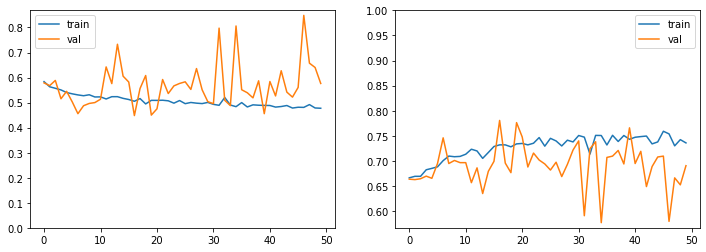

In [15]:
y = np.array([mrk.photo_reqs.hair_across_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'hair_across_eyes')
list_model_files.append(model_file)

#### 10. Eyes Closed  

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6322 - accuracy: 0.5291 - precision: 0.9167 - recall: 0.4524 - f1: 0.5985 - specificity: 0.8248 - negative_predictive_value: 0.2815 - matthews_correlation_coefficient: 0.2335 - val_loss: 0.6914 - val_accuracy: 0.4796 - val_precision: 0.9098 - val_recall: 0.3603 - val_f1: 0.5099 - val_specificity: 0.8805 - val_negative_predictive_value: 0.2649 - val_matthews_correlation_coefficient: 0.2307

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.23072, saving model to ../models/autoencoders_requirements/eyes_closed_2020_03_25-20_35_30.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6237 - accuracy: 0.5430 - precision: 0.9234 - recall: 0.4671 - f1: 0.6082 - specificity: 0.8262 - negative_predictive_value: 0.2858 - matthews_correlation_coefficient: 0.2479 - val_loss: 0.6595 - val_accuracy: 0.5126 - val_precision:


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.34091
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5809 - accuracy: 0.6360 - precision: 0.9221 - recall: 0.5992 - f1: 0.7160 - specificity: 0.7794 - negative_predictive_value: 0.3423 - matthews_correlation_coefficient: 0.3147 - val_loss: 0.5332 - val_accuracy: 0.6921 - val_precision: 0.9036 - val_recall: 0.6934 - val_f1: 0.7802 - val_specificity: 0.7056 - val_negative_predictive_value: 0.3691 - val_matthews_correlation_coefficient: 0.3288

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.34091
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5695 - accuracy: 0.6584 - precision: 0.9163 - recall: 0.6305 - f1: 0.7388 - specificity: 0.7639 - negative_predictive_value: 0.3572 - matthews_correlation_coefficient: 0.3273 - val_loss: 0.5810 - val_accuracy: 0.6444 - val_precision: 0.9272 - val_recall: 0.6099 - val_f1: 0.7289 - val_spe


Epoch 00029: val_matthews_correlation_coefficient improved from 0.36166 to 0.38943, saving model to ../models/autoencoders_requirements/eyes_closed_2020_03_25-20_35_30.h5
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5344 - accuracy: 0.6937 - precision: 0.9178 - recall: 0.6671 - f1: 0.7668 - specificity: 0.7842 - negative_predictive_value: 0.3903 - matthews_correlation_coefficient: 0.3703 - val_loss: 0.5985 - val_accuracy: 0.6435 - val_precision: 0.9162 - val_recall: 0.6158 - val_f1: 0.7320 - val_specificity: 0.7772 - val_negative_predictive_value: 0.3363 - val_matthews_correlation_coefficient: 0.3139

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.38943
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5478 - accuracy: 0.6748 - precision: 0.9265 - recall: 0.6455 - f1: 0.7476 - specificity: 0.7882 - negative_predictive_value: 0.3866 - matthews_correlation_coefficient: 0.3668 - val_loss: 0.6411 - 


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.38943
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5229 - accuracy: 0.6991 - precision: 0.9340 - recall: 0.6740 - f1: 0.7762 - specificity: 0.8053 - negative_predictive_value: 0.3968 - matthews_correlation_coefficient: 0.3944 - val_loss: 0.5021 - val_accuracy: 0.7008 - val_precision: 0.9087 - val_recall: 0.7030 - val_f1: 0.7883 - val_specificity: 0.7076 - val_negative_predictive_value: 0.3731 - val_matthews_correlation_coefficient: 0.3391

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.38943
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5262 - accuracy: 0.6970 - precision: 0.9301 - recall: 0.6718 - f1: 0.7730 - specificity: 0.7893 - negative_predictive_value: 0.3939 - matthews_correlation_coefficient: 0.3838 - val_loss: 0.5581 - val_accuracy: 0.6843 - val_precision: 0.9261 - val_recall: 0.6636 - val_f1: 0.7675 - val_spe


Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.39354
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5106 - accuracy: 0.7180 - precision: 0.9275 - recall: 0.7010 - f1: 0.7917 - specificity: 0.7984 - negative_predictive_value: 0.4073 - matthews_correlation_coefficient: 0.4071 - val_loss: 0.6356 - val_accuracy: 0.6193 - val_precision: 0.9082 - val_recall: 0.5427 - val_f1: 0.6738 - val_specificity: 0.8422 - val_negative_predictive_value: 0.3298 - val_matthews_correlation_coefficient: 0.3290

Epoch 00060: val_matthews_correlation_coefficient did not improve from 0.39354
Epoch 61/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5180 - accuracy: 0.7035 - precision: 0.9266 - recall: 0.6843 - f1: 0.7766 - specificity: 0.7865 - negative_predictive_value: 0.4012 - matthews_correlation_coefficient: 0.3912 - val_loss: 0.7253 - val_accuracy: 0.5958 - val_precision: 0.9291 - val_recall: 0.4996 - val_f1: 0.6436 - val_spe


Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.39675
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5029 - accuracy: 0.7148 - precision: 0.9210 - recall: 0.6904 - f1: 0.7836 - specificity: 0.7849 - negative_predictive_value: 0.4045 - matthews_correlation_coefficient: 0.3913 - val_loss: 0.5348 - val_accuracy: 0.6938 - val_precision: 0.9258 - val_recall: 0.6761 - val_f1: 0.7762 - val_specificity: 0.7849 - val_negative_predictive_value: 0.3814 - val_matthews_correlation_coefficient: 0.3750

Epoch 00075: val_matthews_correlation_coefficient did not improve from 0.39675
Epoch 76/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4949 - accuracy: 0.7321 - precision: 0.9289 - recall: 0.7105 - f1: 0.7993 - specificity: 0.8023 - negative_predictive_value: 0.4282 - matthews_correlation_coefficient: 0.4240 - val_loss: 0.7170 - val_accuracy: 0.5932 - val_precision: 0.9362 - val_recall: 0.5343 - val_f1: 0.6736 - val_spe


Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.39675
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4874 - accuracy: 0.7282 - precision: 0.9228 - recall: 0.7087 - f1: 0.7965 - specificity: 0.7776 - negative_predictive_value: 0.4229 - matthews_correlation_coefficient: 0.4072 - val_loss: 0.6292 - val_accuracy: 0.6271 - val_precision: 0.9231 - val_recall: 0.5444 - val_f1: 0.6808 - val_specificity: 0.8633 - val_negative_predictive_value: 0.3374 - val_matthews_correlation_coefficient: 0.3521

Epoch 00090: val_matthews_correlation_coefficient did not improve from 0.39675
Epoch 91/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4899 - accuracy: 0.7163 - precision: 0.9350 - recall: 0.6926 - f1: 0.7894 - specificity: 0.7970 - negative_predictive_value: 0.4033 - matthews_correlation_coefficient: 0.4056 - val_loss: 0.6442 - val_accuracy: 0.6245 - val_precision: 0.9259 - val_recall: 0.5386 - val_f1: 0.6767 - val_spe

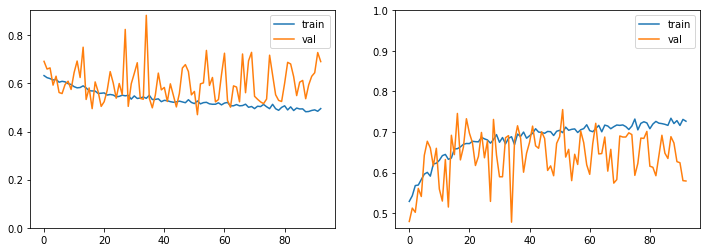

In [16]:
y = np.array([mrk.photo_reqs.eyes_closed.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'eyes_closed')
list_model_files.append(model_file)

#### 11. Varied Background

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5005 - accuracy: 0.7362 - precision: 0.7939 - recall: 0.6999 - f1: 0.7154 - specificity: 0.7688 - negative_predictive_value: 0.7127 - matthews_correlation_coefficient: 0.4884 - val_loss: 0.4825 - val_accuracy: 0.7363 - val_precision: 0.9319 - val_recall: 0.5847 - val_f1: 0.7115 - val_specificity: 0.9208 - val_negative_predictive_value: 0.6173 - val_matthews_correlation_coefficient: 0.5256

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.52562, saving model to ../models/autoencoders_requirements/varied_background_2020_03_25-20_49_16.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4296 - accuracy: 0.7675 - precision: 0.8248 - recall: 0.7658 - f1: 0.7785 - specificity: 0.7804 - negative_predictive_value: 0.7318 - matthews_correlation_coefficient: 0.5524 - val_loss: 0.3820 - val_accuracy: 0.8248 - val_prec


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.69672
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3531 - accuracy: 0.8217 - precision: 0.8595 - recall: 0.8259 - f1: 0.8325 - specificity: 0.8256 - negative_predictive_value: 0.7891 - matthews_correlation_coefficient: 0.6512 - val_loss: 0.3396 - val_accuracy: 0.8248 - val_precision: 0.9319 - val_recall: 0.7514 - val_f1: 0.8269 - val_specificity: 0.9028 - val_negative_predictive_value: 0.7197 - val_matthews_correlation_coefficient: 0.6525

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.69672
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3474 - accuracy: 0.8239 - precision: 0.8663 - recall: 0.8232 - f1: 0.8338 - specificity: 0.8315 - negative_predictive_value: 0.7897 - matthews_correlation_coefficient: 0.6563 - val_loss: 0.3103 - val_accuracy: 0.8630 - val_precision: 0.8886 - val_recall: 0.8690 - val_f1: 0.8764 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3117 - accuracy: 0.8490 - precision: 0.8687 - recall: 0.8482 - f1: 0.8529 - specificity: 0.8407 - negative_predictive_value: 0.8329 - matthews_correlation_coefficient: 0.6965 - val_loss: 0.3446 - val_accuracy: 0.8413 - val_precision: 0.9131 - val_recall: 0.7970 - val_f1: 0.8468 - val_specificity: 0.8782 - val_negative_predictive_value: 0.7560 - val_matthews_correlation_coefficient: 0.6718

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.72121
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3336 - accuracy: 0.8377 - precision: 0.8801 - recall: 0.8315 - f1: 0.8480 - specificity: 0.8589 - negative_predictive_value: 0.8023 - matthews_correlation_coefficient: 0.6860 - val_loss: 0.3333 - val_accuracy: 0.8378 - val_precision: 0.9349 - val_recall: 0.7740 - val_f1: 0.8419 - val_specificity: 0.9027 - val_negative_predictive_value: 0.7371 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2955 - accuracy: 0.8605 - precision: 0.8882 - recall: 0.8488 - f1: 0.8635 - specificity: 0.8757 - negative_predictive_value: 0.8225 - matthews_correlation_coefficient: 0.7189 - val_loss: 0.2755 - val_accuracy: 0.8716 - val_precision: 0.8722 - val_recall: 0.9059 - val_f1: 0.8861 - val_specificity: 0.8097 - val_negative_predictive_value: 0.8506 - val_matthews_correlation_coefficient: 0.7190

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.73441
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3074 - accuracy: 0.8484 - precision: 0.8842 - recall: 0.8421 - f1: 0.8568 - specificity: 0.8607 - negative_predictive_value: 0.8097 - matthews_correlation_coefficient: 0.6980 - val_loss: 0.3019 - val_accuracy: 0.8673 - val_precision: 0.8542 - val_recall: 0.9254 - val_f1: 0.8858 - val_specificity: 0.7738 - val_negative_predictive_value: 0.8689 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2948 - accuracy: 0.8557 - precision: 0.8797 - recall: 0.8507 - f1: 0.8594 - specificity: 0.8623 - negative_predictive_value: 0.8257 - matthews_correlation_coefficient: 0.7103 - val_loss: 0.2742 - val_accuracy: 0.8742 - val_precision: 0.8901 - val_recall: 0.8892 - val_f1: 0.8869 - val_specificity: 0.8382 - val_negative_predictive_value: 0.8328 - val_matthews_correlation_coefficient: 0.7250

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.73441
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2841 - accuracy: 0.8586 - precision: 0.8958 - recall: 0.8450 - f1: 0.8645 - specificity: 0.8718 - negative_predictive_value: 0.8164 - matthews_correlation_coefficient: 0.7158 - val_loss: 0.3031 - val_accuracy: 0.8604 - val_precision: 0.8491 - val_recall: 0.9160 - val_f1: 0.8786 - val_specificity: 0.7711 - val_negative_predictive_value: 0.8583 - val_matthews_correlation_coefficie


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.74104
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2865 - accuracy: 0.8594 - precision: 0.8952 - recall: 0.8481 - f1: 0.8656 - specificity: 0.8656 - negative_predictive_value: 0.8199 - matthews_correlation_coefficient: 0.7156 - val_loss: 0.2762 - val_accuracy: 0.8699 - val_precision: 0.9028 - val_recall: 0.8689 - val_f1: 0.8820 - val_specificity: 0.8542 - val_negative_predictive_value: 0.8141 - val_matthews_correlation_coefficient: 0.7198

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.74104
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2693 - accuracy: 0.8670 - precision: 0.8989 - recall: 0.8573 - f1: 0.8736 - specificity: 0.8748 - negative_predictive_value: 0.8278 - matthews_correlation_coefficient: 0.7308 - val_loss: 0.2863 - val_accuracy: 0.8725 - val_precision: 0.8650 - val_recall: 0.9195 - val_f1: 0.8888 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2645 - accuracy: 0.8746 - precision: 0.8957 - recall: 0.8649 - f1: 0.8763 - specificity: 0.8787 - negative_predictive_value: 0.8394 - matthews_correlation_coefficient: 0.7459 - val_loss: 0.3081 - val_accuracy: 0.8673 - val_precision: 0.8396 - val_recall: 0.9467 - val_f1: 0.8879 - val_specificity: 0.7439 - val_negative_predictive_value: 0.8952 - val_matthews_correlation_coefficient: 0.7115

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.75357
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2696 - accuracy: 0.8685 - precision: 0.8903 - recall: 0.8649 - f1: 0.8720 - specificity: 0.8718 - negative_predictive_value: 0.8453 - matthews_correlation_coefficient: 0.7376 - val_loss: 0.2561 - val_accuracy: 0.8768 - val_precision: 0.8939 - val_recall: 0.8918 - val_f1: 0.8900 - val_specificity: 0.8414 - val_negative_predictive_value: 0.8347 - val_matthews_correlation_coefficie

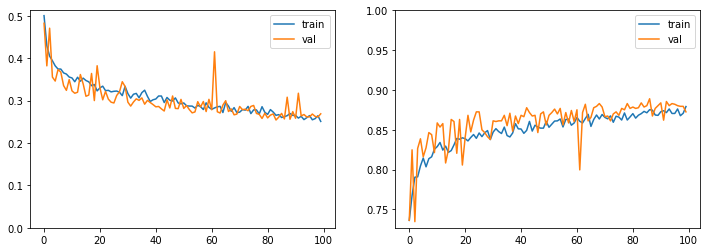

In [17]:
y = np.array([mrk.photo_reqs.varied_background.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'varied_background')
list_model_files.append(model_file)

#### 12. Roll/pitch/yaw

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6053 - accuracy: 0.6928 - precision: 0.8834 - recall: 0.6811 - f1: 0.7643 - specificity: 0.7330 - negative_predictive_value: 0.4371 - matthews_correlation_coefficient: 0.3636 - val_loss: 0.5446 - val_accuracy: 0.7077 - val_precision: 0.8821 - val_recall: 0.6629 - val_f1: 0.7532 - val_specificity: 0.7992 - val_negative_predictive_value: 0.4662 - val_matthews_correlation_coefficient: 0.3988

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.39882, saving model to ../models/autoencoders_requirements/roll_pitch_yaw_2020_03_25-21_04_01.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5901 - accuracy: 0.6970 - precision: 0.8995 - recall: 0.6744 - f1: 0.7662 - specificity: 0.7727 - negative_predictive_value: 0.4383 - matthews_correlation_coefficient: 0.3865 - val_loss: 0.5205 - val_accuracy: 0.7181 - val_precisi

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5697 - accuracy: 0.6998 - precision: 0.9047 - recall: 0.6708 - f1: 0.7661 - specificity: 0.7847 - negative_predictive_value: 0.4441 - matthews_correlation_coefficient: 0.3981 - val_loss: 0.6410 - val_accuracy: 0.6912 - val_precision: 0.8899 - val_recall: 0.6323 - val_f1: 0.7362 - val_specificity: 0.8245 - val_negative_predictive_value: 0.4484 - val_matthews_correlation_coefficient: 0.3908

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.40284
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5749 - accuracy: 0.7004 - precision: 0.8992 - recall: 0.6740 - f1: 0.7663 - specificity: 0.7712 - negative_predictive_value: 0.4443 - matthews_correlation_coefficient: 0.3907 - val_loss: 0.5836 - val_accuracy: 0.7016 - val_precision: 0.8860 - val_recall: 0.6510 - val_f1: 0.7468 - val_specificity: 0.8094 - val_negative_predictive_value: 0.4581 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5628 - accuracy: 0.7043 - precision: 0.9062 - recall: 0.6781 - f1: 0.7721 - specificity: 0.7853 - negative_predictive_value: 0.4465 - matthews_correlation_coefficient: 0.4024 - val_loss: 0.5454 - val_accuracy: 0.7190 - val_precision: 0.8827 - val_recall: 0.6782 - val_f1: 0.7635 - val_specificity: 0.7973 - val_negative_predictive_value: 0.4755 - val_matthews_correlation_coefficient: 0.4105

Epoch 00030: val_matthews_correlation_coefficient improved from 0.40284 to 0.41046, saving model to ../models/autoencoders_requirements/roll_pitch_yaw_2020_03_25-21_04_01.h5
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5629 - accuracy: 0.7082 - precision: 0.9050 - recall: 0.6856 - f1: 0.7763 - specificity: 0.8022 - negative_predictive_value: 0.4592 - matthews_correlation_coefficient: 0.4188 - val_loss: 0.5992 - val_accuracy: 0.7060 - val_precision: 0.8888 - val_recall: 0.6549 - val_f1: 0.7505 - val_s


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.41046
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5594 - accuracy: 0.7106 - precision: 0.9028 - recall: 0.6876 - f1: 0.7767 - specificity: 0.7803 - negative_predictive_value: 0.4501 - matthews_correlation_coefficient: 0.4065 - val_loss: 0.5704 - val_accuracy: 0.7086 - val_precision: 0.8880 - val_recall: 0.6594 - val_f1: 0.7536 - val_specificity: 0.8116 - val_negative_predictive_value: 0.4638 - val_matthews_correlation_coefficient: 0.4047

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.41046
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5642 - accuracy: 0.7063 - precision: 0.8990 - recall: 0.6772 - f1: 0.7688 - specificity: 0.7801 - negative_predictive_value: 0.4472 - matthews_correlation_coefficient: 0.4027 - val_loss: 0.5603 - val_accuracy: 0.7095 - val_precision: 0.8865 - val_recall: 0.6619 - val_f1: 0.7547 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5549 - accuracy: 0.7145 - precision: 0.9081 - recall: 0.6926 - f1: 0.7823 - specificity: 0.7809 - negative_predictive_value: 0.4593 - matthews_correlation_coefficient: 0.4156 - val_loss: 0.5577 - val_accuracy: 0.7077 - val_precision: 0.8822 - val_recall: 0.6624 - val_f1: 0.7536 - val_specificity: 0.8005 - val_negative_predictive_value: 0.4622 - val_matthews_correlation_coefficient: 0.3969

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.41823
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5534 - accuracy: 0.7204 - precision: 0.9084 - recall: 0.7008 - f1: 0.7869 - specificity: 0.7835 - negative_predictive_value: 0.4628 - matthews_correlation_coefficient: 0.4219 - val_loss: 0.5988 - val_accuracy: 0.7042 - val_precision: 0.8886 - val_recall: 0.6528 - val_f1: 0.7491 - val_specificity: 0.8143 - val_negative_predictive_value: 0.4609 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5483 - accuracy: 0.7206 - precision: 0.9074 - recall: 0.7003 - f1: 0.7870 - specificity: 0.7843 - negative_predictive_value: 0.4637 - matthews_correlation_coefficient: 0.4222 - val_loss: 0.5651 - val_accuracy: 0.7121 - val_precision: 0.8876 - val_recall: 0.6650 - val_f1: 0.7567 - val_specificity: 0.8085 - val_negative_predictive_value: 0.4681 - val_matthews_correlation_coefficient: 0.4079

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.41823
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5480 - accuracy: 0.7119 - precision: 0.9022 - recall: 0.6897 - f1: 0.7773 - specificity: 0.7788 - negative_predictive_value: 0.4512 - matthews_correlation_coefficient: 0.4062 - val_loss: 0.6244 - val_accuracy: 0.6964 - val_precision: 0.8901 - val_recall: 0.6405 - val_f1: 0.7416 - val_specificity: 0.8204 - val_negative_predictive_value: 0.4530 - val_matthews_correlation_coefficie


Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.41823
Epoch 00088: early stopping

   Final Accuracy:  72.59%
  Final Precision:  90.65%
     Final Recall:  70.72%
  Final F-measure:  79.45%
Final Specificity:  78.20%
        Final NPV:  47.18%
        Final MCC:  43.02%
[[226  63]
 [253 611]]
              precision    recall  f1-score   support

           0       0.47      0.78      0.59       289
           1       0.91      0.71      0.79       864

    accuracy                           0.73      1153
   macro avg       0.69      0.74      0.69      1153
weighted avg       0.80      0.73      0.74      1153



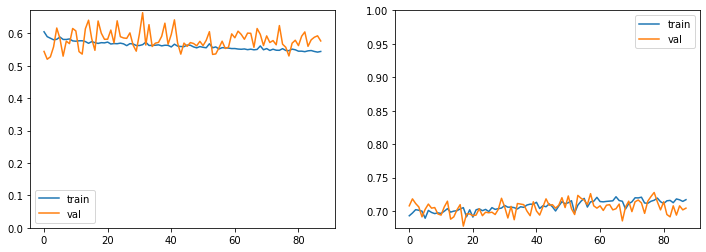

In [18]:
y = np.array([mrk.photo_reqs.roll_pitch_yaw.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'roll_pitch_yaw')
list_model_files.append(model_file)

#### 13. Flash Reflection on Skin

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.6089 - accuracy: 0.6772 - precision: 0.7383 - recall: 0.6974 - f1: 0.7024 - specificity: 0.6518 - negative_predictive_value: 0.6184 - matthews_correlation_coefficient: 0.3540 - val_loss: 0.5901 - val_accuracy: 0.6765 - val_precision: 0.7468 - val_recall: 0.6460 - val_f1: 0.6864 - val_specificity: 0.6729 - val_negative_predictive_value: 0.5662 - val_matthews_correlation_coefficient: 0.3428

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.34281, saving model to ../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_25-21_16_59.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5475 - accuracy: 0.7462 - precision: 0.7826 - recall: 0.8064 - f1: 0.7863 - specificity: 0.6603 - negative_predictive_value: 0.7027 - matthews_correlation_coefficient: 0.4765 - val_loss: 0.5256 - val_accuracy: 0.7632 - 


Epoch 00014: val_matthews_correlation_coefficient improved from 0.57325 to 0.57426, saving model to ../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_25-21_16_59.h5
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4764 - accuracy: 0.7922 - precision: 0.8111 - recall: 0.8573 - f1: 0.8264 - specificity: 0.6990 - negative_predictive_value: 0.7690 - matthews_correlation_coefficient: 0.5688 - val_loss: 0.4437 - val_accuracy: 0.8083 - val_precision: 0.8024 - val_recall: 0.9199 - val_f1: 0.8538 - val_specificity: 0.6265 - val_negative_predictive_value: 0.8159 - val_matthews_correlation_coefficient: 0.5793

Epoch 00015: val_matthews_correlation_coefficient improved from 0.57426 to 0.57933, saving model to ../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_25-21_16_59.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4639 - accuracy: 0.8024 - precision: 0.8036 - recall: 0.8721 - f1: 0.8315 - sp

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4364 - accuracy: 0.8165 - precision: 0.8325 - recall: 0.8721 - f1: 0.8471 - specificity: 0.7304 - negative_predictive_value: 0.7844 - matthews_correlation_coefficient: 0.6106 - val_loss: 0.4723 - val_accuracy: 0.8014 - val_precision: 0.8074 - val_recall: 0.8234 - val_f1: 0.8111 - val_specificity: 0.7162 - val_negative_predictive_value: 0.7451 - val_matthews_correlation_coefficient: 0.5724

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.59824
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4334 - accuracy: 0.8141 - precision: 0.8341 - recall: 0.8633 - f1: 0.8444 - specificity: 0.7383 - negative_predictive_value: 0.7812 - matthews_correlation_coefficient: 0.6078 - val_loss: 0.4317 - val_accuracy: 0.8127 - val_precision: 0.7884 - val_recall: 0.8781 - val_f1: 0.8273 - val_specificity: 0.6615 - val_negative_predictive_value: 0.8056 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4264 - accuracy: 0.8134 - precision: 0.8282 - recall: 0.8543 - f1: 0.8362 - specificity: 0.7423 - negative_predictive_value: 0.7803 - matthews_correlation_coefficient: 0.6019 - val_loss: 0.4565 - val_accuracy: 0.7858 - val_precision: 0.8214 - val_recall: 0.7673 - val_f1: 0.7902 - val_specificity: 0.7609 - val_negative_predictive_value: 0.6914 - val_matthews_correlation_coefficient: 0.5472

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.59824
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4148 - accuracy: 0.8206 - precision: 0.8393 - recall: 0.8534 - f1: 0.8430 - specificity: 0.7572 - negative_predictive_value: 0.7810 - matthews_correlation_coefficient: 0.6217 - val_loss: 0.4374 - val_accuracy: 0.8109 - val_precision: 0.8333 - val_recall: 0.8634 - val_f1: 0.8455 - val_specificity: 0.7115 - val_negative_predictive_value: 0.7636 - val_matthews_correlation_coefficie

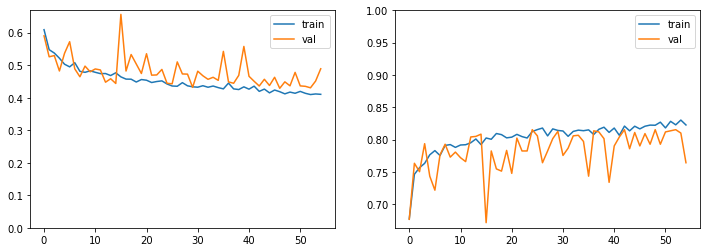

In [19]:
y = np.array([mrk.photo_reqs.flash_reflection_on_skin.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'flash_reflection_on_skin')
list_model_files.append(model_file)

#### 14. Red Eyes 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6337 - accuracy: 0.5302 - precision: 0.9023 - recall: 0.4586 - f1: 0.5991 - specificity: 0.8075 - negative_predictive_value: 0.2852 - matthews_correlation_coefficient: 0.2225 - val_loss: 0.6578 - val_accuracy: 0.4796 - val_precision: 0.9198 - val_recall: 0.3534 - val_f1: 0.5044 - val_specificity: 0.9014 - val_negative_predictive_value: 0.2732 - val_matthews_correlation_coefficient: 0.2473

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.24727, saving model to ../models/autoencoders_requirements/red_eyes_2020_03_25-21_25_14.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6183 - accuracy: 0.5575 - precision: 0.9214 - recall: 0.4876 - f1: 0.6244 - specificity: 0.8063 - negative_predictive_value: 0.2958 - matthews_correlation_coefficient: 0.2515 - val_loss: 0.6596 - val_accuracy: 0.5100 - val_precision: 0


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.36459
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5773 - accuracy: 0.6273 - precision: 0.9284 - recall: 0.5777 - f1: 0.7035 - specificity: 0.8160 - negative_predictive_value: 0.3390 - matthews_correlation_coefficient: 0.3232 - val_loss: 0.6322 - val_accuracy: 0.5594 - val_precision: 0.9082 - val_recall: 0.4643 - val_f1: 0.6100 - val_specificity: 0.8569 - val_negative_predictive_value: 0.3038 - val_matthews_correlation_coefficient: 0.2870

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.36459
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5630 - accuracy: 0.6551 - precision: 0.9296 - recall: 0.6125 - f1: 0.7310 - specificity: 0.8138 - negative_predictive_value: 0.3592 - matthews_correlation_coefficient: 0.3491 - val_loss: 0.5956 - val_accuracy: 0.6505 - val_precision: 0.9023 - val_recall: 0.5926 - val_f1: 0.7102 - val_spe


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.38424
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5389 - accuracy: 0.6861 - precision: 0.9214 - recall: 0.6516 - f1: 0.7558 - specificity: 0.7970 - negative_predictive_value: 0.3874 - matthews_correlation_coefficient: 0.3761 - val_loss: 0.5705 - val_accuracy: 0.6756 - val_precision: 0.9021 - val_recall: 0.6245 - val_f1: 0.7336 - val_specificity: 0.7956 - val_negative_predictive_value: 0.3704 - val_matthews_correlation_coefficient: 0.3644

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.38424
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5363 - accuracy: 0.6800 - precision: 0.9306 - recall: 0.6497 - f1: 0.7578 - specificity: 0.7911 - negative_predictive_value: 0.3812 - matthews_correlation_coefficient: 0.3678 - val_loss: 0.5726 - val_accuracy: 0.6487 - val_precision: 0.8924 - val_recall: 0.5961 - val_f1: 0.7099 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5256 - accuracy: 0.6989 - precision: 0.9235 - recall: 0.6708 - f1: 0.7686 - specificity: 0.8034 - negative_predictive_value: 0.4065 - matthews_correlation_coefficient: 0.3936 - val_loss: 0.6092 - val_accuracy: 0.6444 - val_precision: 0.9164 - val_recall: 0.5723 - val_f1: 0.6991 - val_specificity: 0.8484 - val_negative_predictive_value: 0.3566 - val_matthews_correlation_coefficient: 0.3650

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.39942
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5204 - accuracy: 0.7078 - precision: 0.9287 - recall: 0.6898 - f1: 0.7844 - specificity: 0.7778 - negative_predictive_value: 0.4061 - matthews_correlation_coefficient: 0.3926 - val_loss: 0.5437 - val_accuracy: 0.6852 - val_precision: 0.9036 - val_recall: 0.6362 - val_f1: 0.7424 - val_specificity: 0.7965 - val_negative_predictive_value: 0.3763 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4969 - accuracy: 0.7230 - precision: 0.9246 - recall: 0.7095 - f1: 0.7961 - specificity: 0.7799 - negative_predictive_value: 0.4176 - matthews_correlation_coefficient: 0.4075 - val_loss: 0.7019 - val_accuracy: 0.5915 - val_precision: 0.9120 - val_recall: 0.5041 - val_f1: 0.6439 - val_specificity: 0.8525 - val_negative_predictive_value: 0.3214 - val_matthews_correlation_coefficient: 0.3146

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.39942
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4950 - accuracy: 0.7213 - precision: 0.9260 - recall: 0.6953 - f1: 0.7877 - specificity: 0.8095 - negative_predictive_value: 0.4325 - matthews_correlation_coefficient: 0.4231 - val_loss: 0.7415 - val_accuracy: 0.5811 - val_precision: 0.9180 - val_recall: 0.4875 - val_f1: 0.6310 - val_specificity: 0.8610 - val_negative_predictive_value: 0.3148 - val_matthews_correlation_coefficie

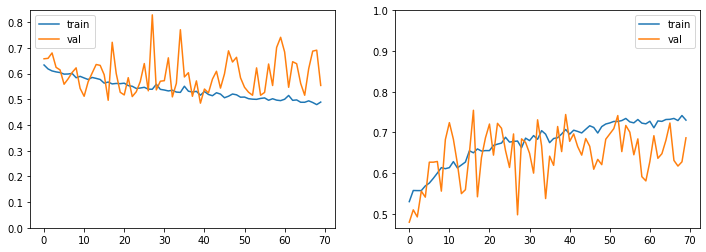

In [20]:
y = np.array([mrk.photo_reqs.red_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'red_eyes')
list_model_files.append(model_file)

#### 15. Shadows Behind Head 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.4963 - accuracy: 0.7466 - precision: 0.8503 - recall: 0.7264 - f1: 0.7747 - specificity: 0.7773 - negative_predictive_value: 0.6153 - matthews_correlation_coefficient: 0.4951 - val_loss: 0.5018 - val_accuracy: 0.7441 - val_precision: 0.8891 - val_recall: 0.6381 - val_f1: 0.7376 - val_specificity: 0.8997 - val_negative_predictive_value: 0.6147 - val_matthews_correlation_coefficient: 0.5191

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.51914, saving model to ../models/autoencoders_requirements/shadows_behind_head_2020_03_25-21_37_59.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4546 - accuracy: 0.7683 - precision: 0.8980 - recall: 0.7232 - f1: 0.7941 - specificity: 0.8651 - negative_predictive_value: 0.6471 - matthews_correlation_coefficient: 0.5652 - val_loss: 0.4775 - val_accuracy: 0.7650 - val_p


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.60965
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3830 - accuracy: 0.8221 - precision: 0.9159 - recall: 0.7921 - f1: 0.8462 - specificity: 0.8796 - negative_predictive_value: 0.7147 - matthews_correlation_coefficient: 0.6501 - val_loss: 0.4562 - val_accuracy: 0.7797 - val_precision: 0.9060 - val_recall: 0.6856 - val_f1: 0.7758 - val_specificity: 0.9131 - val_negative_predictive_value: 0.6531 - val_matthews_correlation_coefficient: 0.5774

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.60965
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3938 - accuracy: 0.8106 - precision: 0.9144 - recall: 0.7741 - f1: 0.8326 - specificity: 0.8723 - negative_predictive_value: 0.6924 - matthews_correlation_coefficient: 0.6269 - val_loss: 0.4336 - val_accuracy: 0.7910 - val_precision: 0.8977 - val_recall: 0.7105 - val_f1: 0.7896 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3634 - accuracy: 0.8341 - precision: 0.9196 - recall: 0.8127 - f1: 0.8586 - specificity: 0.8740 - negative_predictive_value: 0.7271 - matthews_correlation_coefficient: 0.6657 - val_loss: 0.3798 - val_accuracy: 0.8343 - val_precision: 0.8773 - val_recall: 0.8051 - val_f1: 0.8372 - val_specificity: 0.8468 - val_negative_predictive_value: 0.7473 - val_matthews_correlation_coefficient: 0.6373

Epoch 00029: val_matthews_correlation_coefficient improved from 0.63432 to 0.63732, saving model to ../models/autoencoders_requirements/shadows_behind_head_2020_03_25-21_37_59.h5
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3570 - accuracy: 0.8380 - precision: 0.9200 - recall: 0.8181 - f1: 0.8622 - specificity: 0.8735 - negative_predictive_value: 0.7329 - matthews_correlation_coefficient: 0.6712 - val_loss: 0.3887 - val_accuracy: 0.8187 - val_precision: 0.8803 - val_recall: 0.7734 - val_f1: 0.8202 - 


Epoch 00042: val_matthews_correlation_coefficient did not improve from 0.65811
Epoch 43/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3363 - accuracy: 0.8475 - precision: 0.9219 - recall: 0.8280 - f1: 0.8681 - specificity: 0.8816 - negative_predictive_value: 0.7423 - matthews_correlation_coefficient: 0.6875 - val_loss: 0.4018 - val_accuracy: 0.8083 - val_precision: 0.8665 - val_recall: 0.7711 - val_f1: 0.8139 - val_specificity: 0.8410 - val_negative_predictive_value: 0.7065 - val_matthews_correlation_coefficient: 0.5916

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.65811
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3446 - accuracy: 0.8430 - precision: 0.9164 - recall: 0.8163 - f1: 0.8597 - specificity: 0.8810 - negative_predictive_value: 0.7401 - matthews_correlation_coefficient: 0.6826 - val_loss: 0.3932 - val_accuracy: 0.8300 - val_precision: 0.8841 - val_recall: 0.7906 - val_f1: 0.8322 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3404 - accuracy: 0.8477 - precision: 0.9196 - recall: 0.8337 - f1: 0.8710 - specificity: 0.8652 - negative_predictive_value: 0.7516 - matthews_correlation_coefficient: 0.6840 - val_loss: 0.3684 - val_accuracy: 0.8508 - val_precision: 0.8711 - val_recall: 0.8411 - val_f1: 0.8537 - val_specificity: 0.8327 - val_negative_predictive_value: 0.7849 - val_matthews_correlation_coefficient: 0.6644

Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.66811
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3210 - accuracy: 0.8625 - precision: 0.9223 - recall: 0.8475 - f1: 0.8801 - specificity: 0.8824 - negative_predictive_value: 0.7701 - matthews_correlation_coefficient: 0.7122 - val_loss: 0.3688 - val_accuracy: 0.8482 - val_precision: 0.8622 - val_recall: 0.8464 - val_f1: 0.8521 - val_specificity: 0.8139 - val_negative_predictive_value: 0.7921 - val_matthews_correlation_coefficie


Epoch 00071: val_matthews_correlation_coefficient did not improve from 0.67031
Epoch 72/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3218 - accuracy: 0.8612 - precision: 0.9200 - recall: 0.8537 - f1: 0.8814 - specificity: 0.8711 - negative_predictive_value: 0.7714 - matthews_correlation_coefficient: 0.7090 - val_loss: 0.3814 - val_accuracy: 0.8387 - val_precision: 0.9027 - val_recall: 0.7848 - val_f1: 0.8375 - val_specificity: 0.8947 - val_negative_predictive_value: 0.7346 - val_matthews_correlation_coefficient: 0.6574

Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.67031
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3132 - accuracy: 0.8664 - precision: 0.9316 - recall: 0.8502 - f1: 0.8857 - specificity: 0.8871 - negative_predictive_value: 0.7738 - matthews_correlation_coefficient: 0.7220 - val_loss: 0.3648 - val_accuracy: 0.8439 - val_precision: 0.8480 - val_recall: 0.8565 - val_f1: 0.8501 - val_spe


Epoch 00086: val_matthews_correlation_coefficient did not improve from 0.67978
Epoch 87/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3055 - accuracy: 0.8659 - precision: 0.9275 - recall: 0.8561 - f1: 0.8871 - specificity: 0.8805 - negative_predictive_value: 0.7808 - matthews_correlation_coefficient: 0.7214 - val_loss: 0.3542 - val_accuracy: 0.8456 - val_precision: 0.8855 - val_recall: 0.8142 - val_f1: 0.8463 - val_specificity: 0.8594 - val_negative_predictive_value: 0.7615 - val_matthews_correlation_coefficient: 0.6597

Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.67978
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3050 - accuracy: 0.8685 - precision: 0.9219 - recall: 0.8613 - f1: 0.8871 - specificity: 0.8841 - negative_predictive_value: 0.7826 - matthews_correlation_coefficient: 0.7258 - val_loss: 0.3770 - val_accuracy: 0.8352 - val_precision: 0.8941 - val_recall: 0.7882 - val_f1: 0.8349 - val_spe

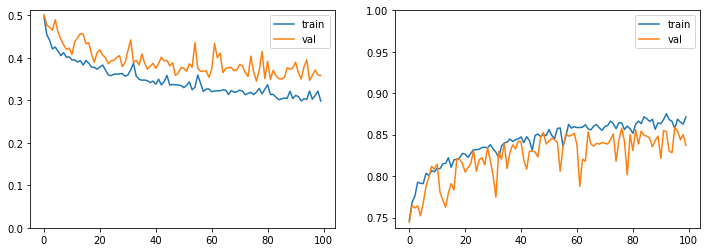

In [21]:
y = np.array([mrk.photo_reqs.shadows_behind_head.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'shadows_behind_head')
list_model_files.append(model_file)

#### 16. Shadows Across Face

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6131 - accuracy: 0.6425 - precision: 0.7181 - recall: 0.6379 - f1: 0.6569 - specificity: 0.6572 - negative_predictive_value: 0.5724 - matthews_correlation_coefficient: 0.3000 - val_loss: 0.5529 - val_accuracy: 0.7268 - val_precision: 0.7008 - val_recall: 0.8772 - val_f1: 0.7722 - val_specificity: 0.4807 - val_negative_predictive_value: 0.7504 - val_matthews_correlation_coefficient: 0.4271

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.42705, saving model to ../models/autoencoders_requirements/shadows_across_face_2020_03_25-21_52_51.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5837 - accuracy: 0.6957 - precision: 0.7495 - recall: 0.7275 - f1: 0.7295 - specificity: 0.6501 - negative_predictive_value: 0.6219 - matthews_correlation_coefficient: 0.3754 - val_loss: 0.5883 - val_accuracy: 0.6739 - val_pr


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.48315
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5202 - accuracy: 0.7412 - precision: 0.7760 - recall: 0.7853 - f1: 0.7727 - specificity: 0.6794 - negative_predictive_value: 0.6932 - matthews_correlation_coefficient: 0.4663 - val_loss: 0.5591 - val_accuracy: 0.6999 - val_precision: 0.7815 - val_recall: 0.6420 - val_f1: 0.6990 - val_specificity: 0.7483 - val_negative_predictive_value: 0.5885 - val_matthews_correlation_coefficient: 0.4065

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.48315
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5139 - accuracy: 0.7505 - precision: 0.7925 - recall: 0.7794 - f1: 0.7782 - specificity: 0.7126 - negative_predictive_value: 0.6978 - matthews_correlation_coefficient: 0.4920 - val_loss: 0.5280 - val_accuracy: 0.7415 - val_precision: 0.7976 - val_recall: 0.7184 - val_f1: 0.7476 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4948 - accuracy: 0.7679 - precision: 0.7952 - recall: 0.8123 - f1: 0.7968 - specificity: 0.6989 - negative_predictive_value: 0.7212 - matthews_correlation_coefficient: 0.5130 - val_loss: 0.4982 - val_accuracy: 0.7554 - val_precision: 0.7245 - val_recall: 0.8827 - val_f1: 0.7903 - val_specificity: 0.5339 - val_negative_predictive_value: 0.7806 - val_matthews_correlation_coefficient: 0.4836

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.53193
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5017 - accuracy: 0.7594 - precision: 0.7950 - recall: 0.8099 - f1: 0.7948 - specificity: 0.6870 - negative_predictive_value: 0.7061 - matthews_correlation_coefficient: 0.5001 - val_loss: 0.4790 - val_accuracy: 0.7762 - val_precision: 0.7519 - val_recall: 0.8664 - val_f1: 0.8000 - val_specificity: 0.6066 - val_negative_predictive_value: 0.7700 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4824 - accuracy: 0.7738 - precision: 0.8104 - recall: 0.8177 - f1: 0.8078 - specificity: 0.7046 - negative_predictive_value: 0.7242 - matthews_correlation_coefficient: 0.5277 - val_loss: 0.4886 - val_accuracy: 0.7641 - val_precision: 0.7330 - val_recall: 0.8771 - val_f1: 0.7944 - val_specificity: 0.5569 - val_negative_predictive_value: 0.7701 - val_matthews_correlation_coefficient: 0.4931

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.53589
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4649 - accuracy: 0.7837 - precision: 0.8130 - recall: 0.8307 - f1: 0.8168 - specificity: 0.7156 - negative_predictive_value: 0.7357 - matthews_correlation_coefficient: 0.5486 - val_loss: 0.4727 - val_accuracy: 0.7719 - val_precision: 0.7730 - val_recall: 0.8184 - val_f1: 0.7894 - val_specificity: 0.6674 - val_negative_predictive_value: 0.7206 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4637 - accuracy: 0.7852 - precision: 0.8204 - recall: 0.8251 - f1: 0.8174 - specificity: 0.7374 - negative_predictive_value: 0.7434 - matthews_correlation_coefficient: 0.5623 - val_loss: 0.4581 - val_accuracy: 0.7901 - val_precision: 0.7944 - val_recall: 0.8198 - val_f1: 0.8015 - val_specificity: 0.7086 - val_negative_predictive_value: 0.7362 - val_matthews_correlation_coefficient: 0.5557

Epoch 00059: val_matthews_correlation_coefficient improved from 0.55064 to 0.55565, saving model to ../models/autoencoders_requirements/shadows_across_face_2020_03_25-21_52_51.h5
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4583 - accuracy: 0.7950 - precision: 0.8302 - recall: 0.8283 - f1: 0.8237 - specificity: 0.7474 - negative_predictive_value: 0.7456 - matthews_correlation_coefficient: 0.5768 - val_loss: 0.4649 - val_accuracy: 0.7927 - val_precision: 0.7800 - val_recall: 0.8489 - val_f1: 0.8081 - 


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.55565
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4527 - accuracy: 0.7907 - precision: 0.8243 - recall: 0.8325 - f1: 0.8224 - specificity: 0.7367 - negative_predictive_value: 0.7562 - matthews_correlation_coefficient: 0.5738 - val_loss: 0.4826 - val_accuracy: 0.7702 - val_precision: 0.8278 - val_recall: 0.7293 - val_f1: 0.7701 - val_specificity: 0.7902 - val_negative_predictive_value: 0.6666 - val_matthews_correlation_coefficient: 0.5332

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.55565
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4542 - accuracy: 0.7909 - precision: 0.8182 - recall: 0.8227 - f1: 0.8154 - specificity: 0.7344 - negative_predictive_value: 0.7426 - matthews_correlation_coefficient: 0.5584 - val_loss: 0.5202 - val_accuracy: 0.7546 - val_precision: 0.7870 - val_recall: 0.7491 - val_f1: 0.7623 - val_spe


Epoch 00088: val_matthews_correlation_coefficient improved from 0.55833 to 0.56323, saving model to ../models/autoencoders_requirements/shadows_across_face_2020_03_25-21_52_51.h5
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4380 - accuracy: 0.8046 - precision: 0.8332 - recall: 0.8445 - f1: 0.8336 - specificity: 0.7555 - negative_predictive_value: 0.7707 - matthews_correlation_coefficient: 0.6012 - val_loss: 0.4666 - val_accuracy: 0.7762 - val_precision: 0.8051 - val_recall: 0.7706 - val_f1: 0.7822 - val_specificity: 0.7470 - val_negative_predictive_value: 0.6941 - val_matthews_correlation_coefficient: 0.5346

Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.56323
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4372 - accuracy: 0.7952 - precision: 0.8286 - recall: 0.8302 - f1: 0.8248 - specificity: 0.7504 - negative_predictive_value: 0.7563 - matthews_correlation_coefficient: 0.5817 - val_loss: 0

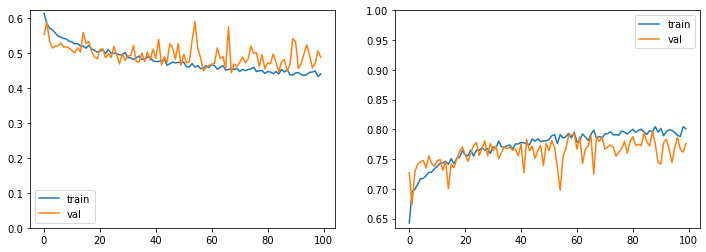

In [22]:
y = np.array([mrk.photo_reqs.shadows_across_face.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'shadows_across_face')
list_model_files.append(model_file)

#### 17. Dark Tinted Lenses

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5776 - accuracy: 0.5362 - precision: 0.9630 - recall: 0.4917 - f1: 0.6452 - specificity: 0.8576 - negative_predictive_value: 0.1822 - matthews_correlation_coefficient: 0.2254 - val_loss: 0.7165 - val_accuracy: 0.4657 - val_precision: 0.9556 - val_recall: 0.3949 - val_f1: 0.5530 - val_specificity: 0.9316 - val_negative_predictive_value: 0.1866 - val_matthews_correlation_coefficient: 0.2134

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.21341, saving model to ../models/autoencoders_requirements/dark_tinted_lenses_2020_03_25-22_07_39.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5594 - accuracy: 0.5644 - precision: 0.9672 - recall: 0.5310 - f1: 0.6773 - specificity: 0.8021 - negative_predictive_value: 0.1880 - matthews_correlation_coefficient: 0.2286 - val_loss: 0.5532 - val_accuracy: 0.5256 - val_pre


Epoch 00014: val_matthews_correlation_coefficient improved from 0.31574 to 0.32630, saving model to ../models/autoencoders_requirements/dark_tinted_lenses_2020_03_25-22_07_39.h5
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4531 - accuracy: 0.7184 - precision: 0.9659 - recall: 0.6996 - f1: 0.8051 - specificity: 0.8323 - negative_predictive_value: 0.2765 - matthews_correlation_coefficient: 0.3575 - val_loss: 0.5992 - val_accuracy: 0.6193 - val_precision: 0.9542 - val_recall: 0.5650 - val_f1: 0.7052 - val_specificity: 0.9077 - val_negative_predictive_value: 0.2354 - val_matthews_correlation_coefficient: 0.2939

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.32630
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4412 - accuracy: 0.7230 - precision: 0.9746 - recall: 0.7101 - f1: 0.8156 - specificity: 0.8325 - negative_predictive_value: 0.2776 - matthews_correlation_coefficient: 0.3617 - val_loss: 0.


Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.43355
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3900 - accuracy: 0.7707 - precision: 0.9836 - recall: 0.7538 - f1: 0.8487 - specificity: 0.8725 - negative_predictive_value: 0.3243 - matthews_correlation_coefficient: 0.4319 - val_loss: 0.3865 - val_accuracy: 0.7832 - val_precision: 0.9473 - val_recall: 0.7567 - val_f1: 0.8385 - val_specificity: 0.8082 - val_negative_predictive_value: 0.3182 - val_matthews_correlation_coefficient: 0.4066

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.43355
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4014 - accuracy: 0.7657 - precision: 0.9779 - recall: 0.7569 - f1: 0.8476 - specificity: 0.8568 - negative_predictive_value: 0.3330 - matthews_correlation_coefficient: 0.4283 - val_loss: 0.4464 - val_accuracy: 0.7398 - val_precision: 0.9582 - val_recall: 0.6975 - val_f1: 0.8049 - val_spe


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.45898
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3917 - accuracy: 0.7740 - precision: 0.9801 - recall: 0.7617 - f1: 0.8490 - specificity: 0.8286 - negative_predictive_value: 0.3388 - matthews_correlation_coefficient: 0.4262 - val_loss: 0.4029 - val_accuracy: 0.7580 - val_precision: 0.9664 - val_recall: 0.7112 - val_f1: 0.8166 - val_specificity: 0.9358 - val_negative_predictive_value: 0.3258 - val_matthews_correlation_coefficient: 0.4271

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.45898
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3711 - accuracy: 0.7720 - precision: 0.9814 - recall: 0.7604 - f1: 0.8522 - specificity: 0.8684 - negative_predictive_value: 0.3247 - matthews_correlation_coefficient: 0.4286 - val_loss: 0.3138 - val_accuracy: 0.8404 - val_precision: 0.9490 - val_recall: 0.8183 - val_f1: 0.8779 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3805 - accuracy: 0.7692 - precision: 0.9765 - recall: 0.7496 - f1: 0.8405 - specificity: 0.8502 - negative_predictive_value: 0.3389 - matthews_correlation_coefficient: 0.4289 - val_loss: 0.6904 - val_accuracy: 0.6271 - val_precision: 0.9713 - val_recall: 0.5638 - val_f1: 0.7092 - val_specificity: 0.9691 - val_negative_predictive_value: 0.2442 - val_matthews_correlation_coefficient: 0.3333

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.48598
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3834 - accuracy: 0.7711 - precision: 0.9807 - recall: 0.7553 - f1: 0.8455 - specificity: 0.8507 - negative_predictive_value: 0.3412 - matthews_correlation_coefficient: 0.4309 - val_loss: 0.4416 - val_accuracy: 0.7398 - val_precision: 0.9688 - val_recall: 0.6891 - val_f1: 0.8027 - val_specificity: 0.9562 - val_negative_predictive_value: 0.3081 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3351 - accuracy: 0.8091 - precision: 0.9833 - recall: 0.8010 - f1: 0.8783 - specificity: 0.8718 - negative_predictive_value: 0.3672 - matthews_correlation_coefficient: 0.4769 - val_loss: 0.5961 - val_accuracy: 0.6800 - val_precision: 0.9713 - val_recall: 0.6216 - val_f1: 0.7545 - val_specificity: 0.9691 - val_negative_predictive_value: 0.2706 - val_matthews_correlation_coefficient: 0.3718

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.48598
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3330 - accuracy: 0.8080 - precision: 0.9833 - recall: 0.7985 - f1: 0.8762 - specificity: 0.8477 - negative_predictive_value: 0.3825 - matthews_correlation_coefficient: 0.4765 - val_loss: 0.6875 - val_accuracy: 0.6409 - val_precision: 0.9712 - val_recall: 0.5788 - val_f1: 0.7221 - val_specificity: 0.9691 - val_negative_predictive_value: 0.2497 - val_matthews_correlation_coefficie

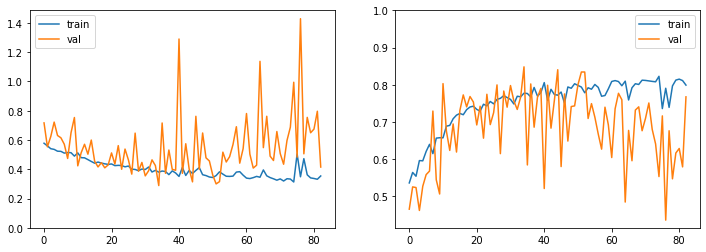

In [23]:
y = np.array([mrk.photo_reqs.dark_tinted_lenses.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'dark_tinted_lenses')
list_model_files.append(model_file)

#### 18. Flash Reflection on Lenses

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5881 - accuracy: 0.6466 - precision: 0.9102 - recall: 0.6189 - f1: 0.7230 - specificity: 0.7341 - negative_predictive_value: 0.3315 - matthews_correlation_coefficient: 0.2970 - val_loss: 0.5790 - val_accuracy: 0.6852 - val_precision: 0.8870 - val_recall: 0.7008 - val_f1: 0.7799 - val_specificity: 0.6234 - val_negative_predictive_value: 0.3513 - val_matthews_correlation_coefficient: 0.2769

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.27687, saving model to ../models/autoencoders_requirements/flash_reflection_on_lenses_2020_03_25-22_20_03.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5741 - accuracy: 0.6774 - precision: 0.9044 - recall: 0.6631 - f1: 0.7584 - specificity: 0.7277 - negative_predictive_value: 0.3713 - matthews_correlation_coefficient: 0.3264 - val_loss: 0.6019 - val_accuracy: 0.6808 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5326 - accuracy: 0.7061 - precision: 0.9168 - recall: 0.6940 - f1: 0.7804 - specificity: 0.7460 - negative_predictive_value: 0.4082 - matthews_correlation_coefficient: 0.3756 - val_loss: 0.6221 - val_accuracy: 0.6288 - val_precision: 0.9171 - val_recall: 0.5489 - val_f1: 0.6818 - val_specificity: 0.8352 - val_negative_predictive_value: 0.3388 - val_matthews_correlation_coefficient: 0.3393

Epoch 00014: val_matthews_correlation_coefficient improved from 0.33818 to 0.33933, saving model to ../models/autoencoders_requirements/flash_reflection_on_lenses_2020_03_25-22_20_03.h5
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5203 - accuracy: 0.7106 - precision: 0.9233 - recall: 0.6924 - f1: 0.7858 - specificity: 0.7762 - negative_predictive_value: 0.4075 - matthews_correlation_coefficient: 0.3913 - val_loss: 0.5757 - val_accuracy: 0.6713 - val_precision: 0.9231 - val_recall: 0.6457 - val_f1: 0.

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5287 - accuracy: 0.6924 - precision: 0.9241 - recall: 0.6668 - f1: 0.7646 - specificity: 0.7937 - negative_predictive_value: 0.3974 - matthews_correlation_coefficient: 0.3829 - val_loss: 0.4766 - val_accuracy: 0.7103 - val_precision: 0.8824 - val_recall: 0.6832 - val_f1: 0.7667 - val_specificity: 0.7083 - val_negative_predictive_value: 0.3923 - val_matthews_correlation_coefficient: 0.3544

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.35974
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5133 - accuracy: 0.7076 - precision: 0.9265 - recall: 0.6850 - f1: 0.7822 - specificity: 0.7946 - negative_predictive_value: 0.4074 - matthews_correlation_coefficient: 0.3974 - val_loss: 0.6343 - val_accuracy: 0.6062 - val_precision: 0.9267 - val_recall: 0.5124 - val_f1: 0.6551 - val_specificity: 0.8669 - val_negative_predictive_value: 0.3287 - val_matthews_correlation_coefficie


Epoch 00042: val_matthews_correlation_coefficient did not improve from 0.38172
Epoch 43/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4856 - accuracy: 0.7458 - precision: 0.9218 - recall: 0.7317 - f1: 0.8101 - specificity: 0.7815 - negative_predictive_value: 0.4546 - matthews_correlation_coefficient: 0.4421 - val_loss: 0.5688 - val_accuracy: 0.6609 - val_precision: 0.9203 - val_recall: 0.5874 - val_f1: 0.7125 - val_specificity: 0.8294 - val_negative_predictive_value: 0.3579 - val_matthews_correlation_coefficient: 0.3664

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.38172
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4870 - accuracy: 0.7332 - precision: 0.9280 - recall: 0.7223 - f1: 0.8050 - specificity: 0.7877 - negative_predictive_value: 0.4453 - matthews_correlation_coefficient: 0.4327 - val_loss: 0.6057 - val_accuracy: 0.6418 - val_precision: 0.9194 - val_recall: 0.5627 - val_f1: 0.6927 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4678 - accuracy: 0.7510 - precision: 0.9210 - recall: 0.7390 - f1: 0.8140 - specificity: 0.7703 - negative_predictive_value: 0.4568 - matthews_correlation_coefficient: 0.4418 - val_loss: 0.6789 - val_accuracy: 0.6279 - val_precision: 0.9259 - val_recall: 0.5404 - val_f1: 0.6763 - val_specificity: 0.8583 - val_negative_predictive_value: 0.3415 - val_matthews_correlation_coefficient: 0.3522

Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.39771
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4634 - accuracy: 0.7588 - precision: 0.9335 - recall: 0.7563 - f1: 0.8283 - specificity: 0.7969 - negative_predictive_value: 0.4855 - matthews_correlation_coefficient: 0.4762 - val_loss: 0.7739 - val_accuracy: 0.6088 - val_precision: 0.9483 - val_recall: 0.5440 - val_f1: 0.6855 - val_specificity: 0.8531 - val_negative_predictive_value: 0.3262 - val_matthews_correlation_coefficie


Epoch 00071: val_matthews_correlation_coefficient did not improve from 0.41092
Epoch 72/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4585 - accuracy: 0.7597 - precision: 0.9292 - recall: 0.7547 - f1: 0.8270 - specificity: 0.7755 - negative_predictive_value: 0.4702 - matthews_correlation_coefficient: 0.4559 - val_loss: 0.4585 - val_accuracy: 0.7572 - val_precision: 0.9209 - val_recall: 0.7640 - val_f1: 0.8320 - val_specificity: 0.7114 - val_negative_predictive_value: 0.4374 - val_matthews_correlation_coefficient: 0.4113

Epoch 00072: val_matthews_correlation_coefficient improved from 0.41092 to 0.41130, saving model to ../models/autoencoders_requirements/flash_reflection_on_lenses_2020_03_25-22_20_03.h5
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4528 - accuracy: 0.7649 - precision: 0.9294 - recall: 0.7628 - f1: 0.8332 - specificity: 0.7819 - negative_predictive_value: 0.4750 - matthews_correlation_coefficient: 0.4646 - val_

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4687 - accuracy: 0.7406 - precision: 0.9374 - recall: 0.7203 - f1: 0.8074 - specificity: 0.7974 - negative_predictive_value: 0.4465 - matthews_correlation_coefficient: 0.4430 - val_loss: 0.5197 - val_accuracy: 0.7112 - val_precision: 0.9000 - val_recall: 0.6684 - val_f1: 0.7635 - val_specificity: 0.7628 - val_negative_predictive_value: 0.3929 - val_matthews_correlation_coefficient: 0.3817

Epoch 00086: val_matthews_correlation_coefficient did not improve from 0.45750
Epoch 87/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4526 - accuracy: 0.7627 - precision: 0.9378 - recall: 0.7509 - f1: 0.8265 - specificity: 0.8159 - negative_predictive_value: 0.4658 - matthews_correlation_coefficient: 0.4753 - val_loss: 0.7427 - val_accuracy: 0.5898 - val_precision: 0.9219 - val_recall: 0.4925 - val_f1: 0.6372 - val_specificity: 0.8643 - val_negative_predictive_value: 0.3183 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4323 - accuracy: 0.7698 - precision: 0.9355 - recall: 0.7496 - f1: 0.8266 - specificity: 0.8267 - negative_predictive_value: 0.4880 - matthews_correlation_coefficient: 0.4912 - val_loss: 0.6273 - val_accuracy: 0.6531 - val_precision: 0.9200 - val_recall: 0.5771 - val_f1: 0.7047 - val_specificity: 0.8383 - val_negative_predictive_value: 0.3550 - val_matthews_correlation_coefficient: 0.3638

Epoch 00100: val_matthews_correlation_coefficient did not improve from 0.47412

   Final Accuracy:  65.31%
  Final Precision:  94.41%
     Final Recall:  59.47%
  Final F-measure:  72.97%
Final Specificity:  86.94%
        Final NPV:  36.66%
        Final MCC:  37.97%
[[213  32]
 [368 540]]
              precision    recall  f1-score   support

           0       0.37      0.87      0.52       245
           1       0.94      0.59      0.73       908

    accuracy                           0.65      1153
   macro avg       0.66      0

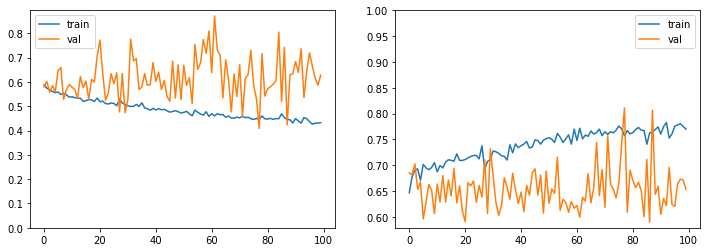

In [24]:
y = np.array([mrk.photo_reqs.flash_reflection_on_lenses.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'flash_reflection_on_lenses')
list_model_files.append(model_file)

#### 19. Frames Too Heavy

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6293 - accuracy: 0.8100 - precision: 0.9981 - recall: 0.8123 - f1: 0.8815 - specificity: 0.0414 - negative_predictive_value: 0.0036 - matthews_correlation_coefficient: 0.0080 - val_loss: 0.1550 - val_accuracy: 0.9870 - val_precision: 0.9983 - val_recall: 0.9890 - val_f1: 0.9935 - val_specificity: 0.0270 - val_negative_predictive_value: 0.0270 - val_matthews_correlation_coefficient: 0.0253

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.02528, saving model to ../models/autoencoders_requirements/frames_too_heavy_2020_03_25-22_35_06.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5696 - accuracy: 0.7510 - precision: 0.9984 - recall: 0.7536 - f1: 0.8448 - specificity: 0.0483 - negative_predictive_value: 0.0061 - matthews_correlation_coefficient: 0.0133 - val_loss: 0.1638 - val_accuracy: 0.9324 - val_prec

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2981 - accuracy: 0.8432 - precision: 0.9996 - recall: 0.8440 - f1: 0.9083 - specificity: 0.0690 - negative_predictive_value: 0.0137 - matthews_correlation_coefficient: 0.0256 - val_loss: 0.3009 - val_accuracy: 0.8187 - val_precision: 1.0000 - val_recall: 0.8233 - val_f1: 0.9016 - val_specificity: 0.0811 - val_negative_predictive_value: 0.0225 - val_matthews_correlation_coefficient: 0.0408

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.05405
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3849 - accuracy: 0.8538 - precision: 0.9996 - recall: 0.8548 - f1: 0.9161 - specificity: 0.0828 - negative_predictive_value: 0.0221 - matthews_correlation_coefficient: 0.0378 - val_loss: 0.4909 - val_accuracy: 0.7329 - val_precision: 1.0000 - val_recall: 0.7392 - val_f1: 0.8483 - val_specificity: 0.0811 - val_negative_predictive_value: 0.0097 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2146 - accuracy: 0.9289 - precision: 0.9998 - recall: 0.9292 - f1: 0.9622 - specificity: 0.0897 - negative_predictive_value: 0.0280 - matthews_correlation_coefficient: 0.0458 - val_loss: 0.4318 - val_accuracy: 0.7728 - val_precision: 1.0000 - val_recall: 0.7782 - val_f1: 0.8739 - val_specificity: 0.0811 - val_negative_predictive_value: 0.0117 - val_matthews_correlation_coefficient: 0.0277

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.07285
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1566 - accuracy: 0.9048 - precision: 1.0000 - recall: 0.9052 - f1: 0.9478 - specificity: 0.0897 - negative_predictive_value: 0.0382 - matthews_correlation_coefficient: 0.0552 - val_loss: 0.1382 - val_accuracy: 0.9488 - val_precision: 1.0000 - val_recall: 0.9501 - val_f1: 0.9740 - val_specificity: 0.0811 - val_negative_predictive_value: 0.0495 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.08108
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.0527 - accuracy: 0.9742 - precision: 1.0000 - recall: 0.9743 - f1: 0.9865 - specificity: 0.0897 - negative_predictive_value: 0.0730 - matthews_correlation_coefficient: 0.0788 - val_loss: 0.0183 - val_accuracy: 0.9931 - val_precision: 1.0000 - val_recall: 0.9932 - val_f1: 0.9966 - val_specificity: 0.0811 - val_negative_predictive_value: 0.0811 - val_matthews_correlation_coefficient: 0.0811

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.08108
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.0411 - accuracy: 0.9790 - precision: 1.0000 - recall: 0.9790 - f1: 0.9891 - specificity: 0.0966 - negative_predictive_value: 0.0764 - matthews_correlation_coefficient: 0.0836 - val_loss: 0.0140 - val_accuracy: 0.9957 - val_precision: 0.9992 - val_recall: 0.9966 - val_f1: 0.9979 - val_spe


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.08108
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1564 - accuracy: 0.9013 - precision: 0.9998 - recall: 0.9019 - f1: 0.9458 - specificity: 0.0897 - negative_predictive_value: 0.0378 - matthews_correlation_coefficient: 0.0521 - val_loss: 0.0160 - val_accuracy: 0.9957 - val_precision: 0.9992 - val_recall: 0.9966 - val_f1: 0.9979 - val_specificity: 0.0541 - val_negative_predictive_value: 0.0541 - val_matthews_correlation_coefficient: 0.0541

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.08108
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.0452 - accuracy: 0.9842 - precision: 1.0000 - recall: 0.9843 - f1: 0.9918 - specificity: 0.0966 - negative_predictive_value: 0.0931 - matthews_correlation_coefficient: 0.0945 - val_loss: 0.0297 - val_accuracy: 0.9913 - val_precision: 1.0000 - val_recall: 0.9916 - val_f1: 0.9957 - val_spe

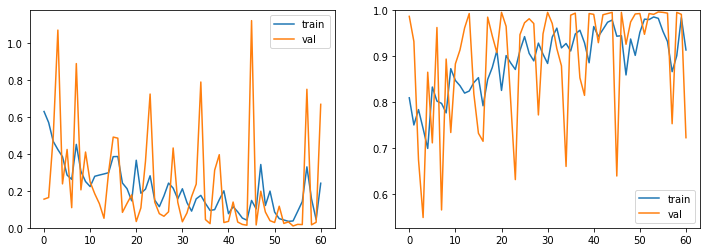

In [25]:
y = np.array([mrk.photo_reqs.frames_too_heavy.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'frames_too_heavy')
list_model_files.append(model_file)

#### 20. Frame Covering Eyes  

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6027 - accuracy: 0.6154 - precision: 0.8848 - recall: 0.5490 - f1: 0.6609 - specificity: 0.8085 - negative_predictive_value: 0.4153 - matthews_correlation_coefficient: 0.3259 - val_loss: 0.6108 - val_accuracy: 0.6106 - val_precision: 0.9214 - val_recall: 0.5112 - val_f1: 0.6486 - val_specificity: 0.8559 - val_negative_predictive_value: 0.3993 - val_matthews_correlation_coefficient: 0.3413

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.34133, saving model to ../models/autoencoders_requirements/frame_covering_eyes_2020_03_25-22_44_20.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5816 - accuracy: 0.6304 - precision: 0.9062 - recall: 0.5493 - f1: 0.6749 - specificity: 0.8499 - negative_predictive_value: 0.4317 - matthews_correlation_coefficient: 0.3658 - val_loss: 0.6063 - val_accuracy: 0.6071 - val_p

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5354 - accuracy: 0.6896 - precision: 0.9126 - recall: 0.6305 - f1: 0.7398 - specificity: 0.8375 - negative_predictive_value: 0.4710 - matthews_correlation_coefficient: 0.4234 - val_loss: 0.5677 - val_accuracy: 0.6565 - val_precision: 0.9306 - val_recall: 0.5732 - val_f1: 0.7040 - val_specificity: 0.8674 - val_negative_predictive_value: 0.4340 - val_matthews_correlation_coefficient: 0.3992

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.40949
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5291 - accuracy: 0.6922 - precision: 0.9141 - recall: 0.6344 - f1: 0.7412 - specificity: 0.8435 - negative_predictive_value: 0.4737 - matthews_correlation_coefficient: 0.4307 - val_loss: 0.5173 - val_accuracy: 0.7138 - val_precision: 0.8880 - val_recall: 0.6948 - val_f1: 0.7770 - val_specificity: 0.7548 - val_negative_predictive_value: 0.4793 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.43370
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5057 - accuracy: 0.7100 - precision: 0.9263 - recall: 0.6522 - f1: 0.7590 - specificity: 0.8650 - negative_predictive_value: 0.5009 - matthews_correlation_coefficient: 0.4684 - val_loss: 0.6195 - val_accuracy: 0.6505 - val_precision: 0.9326 - val_recall: 0.5616 - val_f1: 0.6956 - val_specificity: 0.8724 - val_negative_predictive_value: 0.4290 - val_matthews_correlation_coefficient: 0.3943

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.43370
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5037 - accuracy: 0.7163 - precision: 0.9269 - recall: 0.6575 - f1: 0.7637 - specificity: 0.8606 - negative_predictive_value: 0.4976 - matthews_correlation_coefficient: 0.4687 - val_loss: 0.6358 - val_accuracy: 0.6331 - val_precision: 0.9301 - val_recall: 0.5370 - val_f1: 0.6739 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4913 - accuracy: 0.7252 - precision: 0.9179 - recall: 0.6689 - f1: 0.7675 - specificity: 0.8593 - negative_predictive_value: 0.5105 - matthews_correlation_coefficient: 0.4802 - val_loss: 0.5244 - val_accuracy: 0.7016 - val_precision: 0.9049 - val_recall: 0.6580 - val_f1: 0.7567 - val_specificity: 0.8052 - val_negative_predictive_value: 0.4742 - val_matthews_correlation_coefficient: 0.4178

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.44034
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4908 - accuracy: 0.7284 - precision: 0.9296 - recall: 0.6783 - f1: 0.7789 - specificity: 0.8665 - negative_predictive_value: 0.5186 - matthews_correlation_coefficient: 0.4920 - val_loss: 0.4982 - val_accuracy: 0.7207 - val_precision: 0.8933 - val_recall: 0.6984 - val_f1: 0.7806 - val_specificity: 0.7691 - val_negative_predictive_value: 0.4904 - val_matthews_correlation_coefficie


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.45107
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4850 - accuracy: 0.7310 - precision: 0.9302 - recall: 0.6787 - f1: 0.7788 - specificity: 0.8595 - negative_predictive_value: 0.5168 - matthews_correlation_coefficient: 0.4905 - val_loss: 0.5279 - val_accuracy: 0.7077 - val_precision: 0.9262 - val_recall: 0.6510 - val_f1: 0.7605 - val_specificity: 0.8400 - val_negative_predictive_value: 0.4750 - val_matthews_correlation_coefficient: 0.4425

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.45107
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4747 - accuracy: 0.7347 - precision: 0.9191 - recall: 0.6834 - f1: 0.7786 - specificity: 0.8461 - negative_predictive_value: 0.5190 - matthews_correlation_coefficient: 0.4799 - val_loss: 0.5178 - val_accuracy: 0.7173 - val_precision: 0.9094 - val_recall: 0.6794 - val_f1: 0.7736 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4684 - accuracy: 0.7393 - precision: 0.9243 - recall: 0.6981 - f1: 0.7895 - specificity: 0.8485 - negative_predictive_value: 0.5267 - matthews_correlation_coefficient: 0.4946 - val_loss: 0.5057 - val_accuracy: 0.7155 - val_precision: 0.8984 - val_recall: 0.6886 - val_f1: 0.7760 - val_specificity: 0.7732 - val_negative_predictive_value: 0.4811 - val_matthews_correlation_coefficient: 0.4176

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.46822
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4672 - accuracy: 0.7512 - precision: 0.9294 - recall: 0.7136 - f1: 0.8017 - specificity: 0.8479 - negative_predictive_value: 0.5358 - matthews_correlation_coefficient: 0.5086 - val_loss: 0.5208 - val_accuracy: 0.7121 - val_precision: 0.9072 - val_recall: 0.6747 - val_f1: 0.7704 - val_specificity: 0.7981 - val_negative_predictive_value: 0.4784 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4627 - accuracy: 0.7449 - precision: 0.9262 - recall: 0.7046 - f1: 0.7939 - specificity: 0.8521 - negative_predictive_value: 0.5318 - matthews_correlation_coefficient: 0.5044 - val_loss: 0.5113 - val_accuracy: 0.7259 - val_precision: 0.9266 - val_recall: 0.6779 - val_f1: 0.7794 - val_specificity: 0.8357 - val_negative_predictive_value: 0.4925 - val_matthews_correlation_coefficient: 0.4627

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.46822
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4537 - accuracy: 0.7505 - precision: 0.9274 - recall: 0.7061 - f1: 0.7974 - specificity: 0.8534 - negative_predictive_value: 0.5346 - matthews_correlation_coefficient: 0.5084 - val_loss: 0.5360 - val_accuracy: 0.7060 - val_precision: 0.9353 - val_recall: 0.6402 - val_f1: 0.7557 - val_specificity: 0.8648 - val_negative_predictive_value: 0.4753 - val_matthews_correlation_coefficie

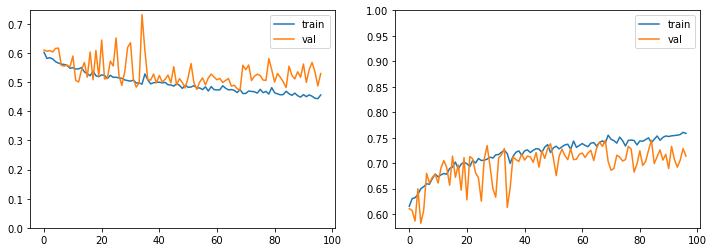

In [26]:
y = np.array([mrk.photo_reqs.frame_covering_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'frame_covering_eyes')
list_model_files.append(model_file)

#### 21. Hat/cap 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6024 - accuracy: 0.6054 - precision: 0.9273 - recall: 0.5928 - f1: 0.7069 - specificity: 0.7024 - negative_predictive_value: 0.2150 - matthews_correlation_coefficient: 0.2066 - val_loss: 0.5326 - val_accuracy: 0.6756 - val_precision: 0.8929 - val_recall: 0.6610 - val_f1: 0.7568 - val_specificity: 0.6338 - val_negative_predictive_value: 0.2479 - val_matthews_correlation_coefficient: 0.2293

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.22933, saving model to ../models/autoencoders_requirements/hat_cap_2020_03_25-22_58_50.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5487 - accuracy: 0.6464 - precision: 0.9438 - recall: 0.6265 - f1: 0.7438 - specificity: 0.7590 - negative_predictive_value: 0.2675 - matthews_correlation_coefficient: 0.2832 - val_loss: 0.7275 - val_accuracy: 0.5421 - val_precision: 0.


Epoch 00014: val_matthews_correlation_coefficient improved from 0.32203 to 0.33013, saving model to ../models/autoencoders_requirements/hat_cap_2020_03_25-22_58_50.h5
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4798 - accuracy: 0.7273 - precision: 0.9501 - recall: 0.7217 - f1: 0.8148 - specificity: 0.7668 - negative_predictive_value: 0.3253 - matthews_correlation_coefficient: 0.3619 - val_loss: 0.4908 - val_accuracy: 0.7164 - val_precision: 0.9190 - val_recall: 0.6926 - val_f1: 0.7851 - val_specificity: 0.7486 - val_negative_predictive_value: 0.3308 - val_matthews_correlation_coefficient: 0.3248

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.33013
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4902 - accuracy: 0.7223 - precision: 0.9447 - recall: 0.7102 - f1: 0.8018 - specificity: 0.7765 - negative_predictive_value: 0.3393 - matthews_correlation_coefficient: 0.3710 - val_loss: 0.4838 - val_

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4334 - accuracy: 0.7525 - precision: 0.9591 - recall: 0.7462 - f1: 0.8348 - specificity: 0.8076 - negative_predictive_value: 0.3544 - matthews_correlation_coefficient: 0.4091 - val_loss: 0.3788 - val_accuracy: 0.7971 - val_precision: 0.8891 - val_recall: 0.8199 - val_f1: 0.8514 - val_specificity: 0.5080 - val_negative_predictive_value: 0.3845 - val_matthews_correlation_coefficient: 0.2959

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.36537
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4373 - accuracy: 0.7523 - precision: 0.9636 - recall: 0.7422 - f1: 0.8337 - specificity: 0.8305 - negative_predictive_value: 0.3678 - matthews_correlation_coefficient: 0.4282 - val_loss: 0.3913 - val_accuracy: 0.7875 - val_precision: 0.9100 - val_recall: 0.7862 - val_f1: 0.8415 - val_specificity: 0.6878 - val_negative_predictive_value: 0.3967 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3977 - accuracy: 0.7844 - precision: 0.9661 - recall: 0.7782 - f1: 0.8584 - specificity: 0.8290 - negative_predictive_value: 0.3996 - matthews_correlation_coefficient: 0.4639 - val_loss: 0.3758 - val_accuracy: 0.8014 - val_precision: 0.9075 - val_recall: 0.8059 - val_f1: 0.8517 - val_specificity: 0.6410 - val_negative_predictive_value: 0.4089 - val_matthews_correlation_coefficient: 0.3695

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.39111
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4019 - accuracy: 0.7688 - precision: 0.9642 - recall: 0.7602 - f1: 0.8460 - specificity: 0.8364 - negative_predictive_value: 0.3810 - matthews_correlation_coefficient: 0.4475 - val_loss: 0.3345 - val_accuracy: 0.8326 - val_precision: 0.8915 - val_recall: 0.8617 - val_f1: 0.8747 - val_specificity: 0.5157 - val_negative_predictive_value: 0.4440 - val_matthews_correlation_coefficie


Epoch 00057: val_matthews_correlation_coefficient improved from 0.42095 to 0.45445, saving model to ../models/autoencoders_requirements/hat_cap_2020_03_25-22_58_50.h5
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3745 - accuracy: 0.7935 - precision: 0.9642 - recall: 0.7879 - f1: 0.8630 - specificity: 0.8075 - negative_predictive_value: 0.4043 - matthews_correlation_coefficient: 0.4660 - val_loss: 0.3880 - val_accuracy: 0.7918 - val_precision: 0.9210 - val_recall: 0.7811 - val_f1: 0.8428 - val_specificity: 0.7243 - val_negative_predictive_value: 0.4078 - val_matthews_correlation_coefficient: 0.4011

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.45445
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4235 - accuracy: 0.7614 - precision: 0.9624 - recall: 0.7550 - f1: 0.8376 - specificity: 0.8151 - negative_predictive_value: 0.3743 - matthews_correlation_coefficient: 0.4297 - val_loss: 0.3658 - val_


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.45445
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3659 - accuracy: 0.7952 - precision: 0.9743 - recall: 0.7853 - f1: 0.8653 - specificity: 0.8603 - negative_predictive_value: 0.4148 - matthews_correlation_coefficient: 0.4931 - val_loss: 0.3352 - val_accuracy: 0.8413 - val_precision: 0.9018 - val_recall: 0.8605 - val_f1: 0.8793 - val_specificity: 0.5722 - val_negative_predictive_value: 0.4653 - val_matthews_correlation_coefficient: 0.3941

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.45445
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3589 - accuracy: 0.8048 - precision: 0.9710 - recall: 0.7977 - f1: 0.8717 - specificity: 0.8622 - negative_predictive_value: 0.4396 - matthews_correlation_coefficient: 0.5118 - val_loss: 0.3477 - val_accuracy: 0.8300 - val_precision: 0.9064 - val_recall: 0.8417 - val_f1: 0.8713 - val_spe

Restoring model weights from the end of the best epoch

Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.45445
Epoch 00087: early stopping

   Final Accuracy:  86.73%
  Final Precision:  92.27%
     Final Recall:  92.17%
  Final F-measure:  92.22%
Final Specificity:  55.03%
        Final NPV:  54.71%
        Final MCC:  47.09%
[[ 93  76]
 [ 77 907]]
              precision    recall  f1-score   support

           0       0.55      0.55      0.55       169
           1       0.92      0.92      0.92       984

    accuracy                           0.87      1153
   macro avg       0.73      0.74      0.74      1153
weighted avg       0.87      0.87      0.87      1153



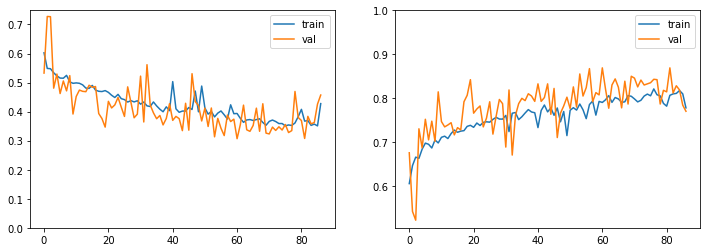

In [27]:
y = np.array([mrk.photo_reqs.hat_cap.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'hat_cap')
list_model_files.append(model_file)

#### *22. Veil Over Face*

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.4151 - accuracy: 0.7818 - precision: 0.9921 - recall: 0.7720 - f1: 0.8622 - specificity: 0.8027 - negative_predictive_value: 0.2278 - matthews_correlation_coefficient: 0.3544 - val_loss: 0.3807 - val_accuracy: 0.8387 - val_precision: 0.9643 - val_recall: 0.8136 - val_f1: 0.8811 - val_specificity: 0.7748 - val_negative_predictive_value: 0.2588 - val_matthews_correlation_coefficient: 0.3829

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.38286, saving model to ../models/autoencoders_requirements/veil_over_face_2020_03_25-23_11_55.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3224 - accuracy: 0.8698 - precision: 0.9917 - recall: 0.8666 - f1: 0.9230 - specificity: 0.7196 - negative_predictive_value: 0.3117 - matthews_correlation_coefficient: 0.4179 - val_loss: 0.4039 - val_accuracy: 0.8491 - val_precis


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.53481
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2420 - accuracy: 0.9137 - precision: 0.9932 - recall: 0.9151 - f1: 0.9512 - specificity: 0.8032 - negative_predictive_value: 0.4458 - matthews_correlation_coefficient: 0.5529 - val_loss: 0.1638 - val_accuracy: 0.9402 - val_precision: 0.9635 - val_recall: 0.9206 - val_f1: 0.9412 - val_specificity: 0.7477 - val_negative_predictive_value: 0.4653 - val_matthews_correlation_coefficient: 0.5518

Epoch 00015: val_matthews_correlation_coefficient improved from 0.53481 to 0.55181, saving model to ../models/autoencoders_requirements/veil_over_face_2020_03_25-23_11_55.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2521 - accuracy: 0.9111 - precision: 0.9915 - recall: 0.9133 - f1: 0.9495 - specificity: 0.7800 - negative_predictive_value: 0.4183 - matthews_correlation_coefficient: 0.5216 - val_loss: 0.2118

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2013 - accuracy: 0.9367 - precision: 0.9937 - recall: 0.9359 - f1: 0.9627 - specificity: 0.7568 - negative_predictive_value: 0.4992 - matthews_correlation_coefficient: 0.5786 - val_loss: 0.1349 - val_accuracy: 0.9618 - val_precision: 0.9908 - val_recall: 0.9692 - val_f1: 0.9796 - val_specificity: 0.7658 - val_negative_predictive_value: 0.5844 - val_matthews_correlation_coefficient: 0.6389

Epoch 00029: val_matthews_correlation_coefficient improved from 0.59435 to 0.63893, saving model to ../models/autoencoders_requirements/veil_over_face_2020_03_25-23_11_55.h5
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2280 - accuracy: 0.9260 - precision: 0.9887 - recall: 0.9293 - f1: 0.9561 - specificity: 0.7759 - negative_predictive_value: 0.4853 - matthews_correlation_coefficient: 0.5692 - val_loss: 0.4017 - val_accuracy: 0.8846 - val_precision: 0.9668 - val_recall: 0.8596 - val_f1: 0.9093 - val_s


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.63893
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1749 - accuracy: 0.9434 - precision: 0.9947 - recall: 0.9450 - f1: 0.9683 - specificity: 0.7918 - negative_predictive_value: 0.5377 - matthews_correlation_coefficient: 0.6144 - val_loss: 0.1421 - val_accuracy: 0.9584 - val_precision: 0.9944 - val_recall: 0.9622 - val_f1: 0.9776 - val_specificity: 0.8063 - val_negative_predictive_value: 0.5943 - val_matthews_correlation_coefficient: 0.6614

Epoch 00044: val_matthews_correlation_coefficient improved from 0.63893 to 0.66135, saving model to ../models/autoencoders_requirements/veil_over_face_2020_03_25-23_11_55.h5
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1669 - accuracy: 0.9525 - precision: 0.9940 - recall: 0.9554 - f1: 0.9738 - specificity: 0.8133 - negative_predictive_value: 0.5938 - matthews_correlation_coefficient: 0.6608 - val_loss: 0.3109

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1426 - accuracy: 0.9553 - precision: 0.9956 - recall: 0.9573 - f1: 0.9754 - specificity: 0.7998 - negative_predictive_value: 0.6052 - matthews_correlation_coefficient: 0.6648 - val_loss: 0.2973 - val_accuracy: 0.9011 - val_precision: 0.9700 - val_recall: 0.8740 - val_f1: 0.9189 - val_specificity: 0.8333 - val_negative_predictive_value: 0.3627 - val_matthews_correlation_coefficient: 0.5044

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.71557
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1717 - accuracy: 0.9453 - precision: 0.9949 - recall: 0.9469 - f1: 0.9688 - specificity: 0.8375 - negative_predictive_value: 0.5878 - matthews_correlation_coefficient: 0.6648 - val_loss: 0.3690 - val_accuracy: 0.8751 - val_precision: 0.9678 - val_recall: 0.8489 - val_f1: 0.9038 - val_specificity: 0.8198 - val_negative_predictive_value: 0.3081 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1350 - accuracy: 0.9618 - precision: 0.9960 - recall: 0.9637 - f1: 0.9791 - specificity: 0.8340 - negative_predictive_value: 0.6286 - matthews_correlation_coefficient: 0.6933 - val_loss: 0.2723 - val_accuracy: 0.8673 - val_precision: 0.9698 - val_recall: 0.8383 - val_f1: 0.8985 - val_specificity: 0.8333 - val_negative_predictive_value: 0.2974 - val_matthews_correlation_coefficient: 0.4485

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.71557
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1272 - accuracy: 0.9547 - precision: 0.9962 - recall: 0.9558 - f1: 0.9748 - specificity: 0.8389 - negative_predictive_value: 0.6110 - matthews_correlation_coefficient: 0.6828 - val_loss: 0.1687 - val_accuracy: 0.9237 - val_precision: 0.9959 - val_recall: 0.9239 - val_f1: 0.9581 - val_specificity: 0.8279 - val_negative_predictive_value: 0.4172 - val_matthews_correlation_coefficie

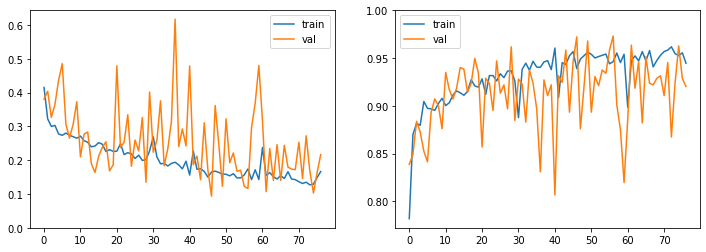

In [28]:
y = np.array([mrk.photo_reqs.veil_over_face.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'veil_over_face')
list_model_files.append(model_file)

#### 23. Mouth Open 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6067 - accuracy: 0.6518 - precision: 0.8783 - recall: 0.6234 - f1: 0.7177 - specificity: 0.7493 - negative_predictive_value: 0.4118 - matthews_correlation_coefficient: 0.3305 - val_loss: 0.6378 - val_accuracy: 0.6123 - val_precision: 0.8515 - val_recall: 0.5341 - val_f1: 0.6495 - val_specificity: 0.7958 - val_negative_predictive_value: 0.4068 - val_matthews_correlation_coefficient: 0.2906

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.29059, saving model to ../models/autoencoders_requirements/mouth_open_2020_03_25-23_23_28.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5807 - accuracy: 0.6679 - precision: 0.8845 - recall: 0.6353 - f1: 0.7295 - specificity: 0.7649 - negative_predictive_value: 0.4342 - matthews_correlation_coefficient: 0.3567 - val_loss: 0.6701 - val_accuracy: 0.6071 - val_precision:


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.37281
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5442 - accuracy: 0.6961 - precision: 0.8866 - recall: 0.6635 - f1: 0.7536 - specificity: 0.7772 - negative_predictive_value: 0.4595 - matthews_correlation_coefficient: 0.3903 - val_loss: 0.6479 - val_accuracy: 0.6583 - val_precision: 0.8639 - val_recall: 0.5941 - val_f1: 0.6994 - val_specificity: 0.7985 - val_negative_predictive_value: 0.4394 - val_matthews_correlation_coefficient: 0.3434

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.37281
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5450 - accuracy: 0.6967 - precision: 0.8912 - recall: 0.6680 - f1: 0.7588 - specificity: 0.7743 - negative_predictive_value: 0.4580 - matthews_correlation_coefficient: 0.3927 - val_loss: 0.5965 - val_accuracy: 0.6808 - val_precision: 0.8495 - val_recall: 0.6418 - val_f1: 0.7271 - val_spe


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.38598
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5285 - accuracy: 0.7156 - precision: 0.9046 - recall: 0.6867 - f1: 0.7748 - specificity: 0.7893 - negative_predictive_value: 0.4803 - matthews_correlation_coefficient: 0.4278 - val_loss: 0.5813 - val_accuracy: 0.6886 - val_precision: 0.8477 - val_recall: 0.6565 - val_f1: 0.7361 - val_specificity: 0.7426 - val_negative_predictive_value: 0.4630 - val_matthews_correlation_coefficient: 0.3505

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.38598
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5367 - accuracy: 0.7087 - precision: 0.8936 - recall: 0.6758 - f1: 0.7640 - specificity: 0.7840 - negative_predictive_value: 0.4746 - matthews_correlation_coefficient: 0.4118 - val_loss: 0.5772 - val_accuracy: 0.6739 - val_precision: 0.8574 - val_recall: 0.6229 - val_f1: 0.7172 - val_spe


Epoch 00044: val_matthews_correlation_coefficient improved from 0.38827 to 0.39000, saving model to ../models/autoencoders_requirements/mouth_open_2020_03_25-23_23_28.h5
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5181 - accuracy: 0.7124 - precision: 0.9016 - recall: 0.6837 - f1: 0.7715 - specificity: 0.7857 - negative_predictive_value: 0.4755 - matthews_correlation_coefficient: 0.4199 - val_loss: 0.5027 - val_accuracy: 0.7225 - val_precision: 0.8401 - val_recall: 0.7206 - val_f1: 0.7723 - val_specificity: 0.6966 - val_negative_predictive_value: 0.5031 - val_matthews_correlation_coefficient: 0.3765

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.39000
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5160 - accuracy: 0.7271 - precision: 0.8896 - recall: 0.7096 - f1: 0.7842 - specificity: 0.7679 - negative_predictive_value: 0.4947 - matthews_correlation_coefficient: 0.4262 - val_loss: 0.6297 - v


Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.39000
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5090 - accuracy: 0.7126 - precision: 0.9031 - recall: 0.6817 - f1: 0.7722 - specificity: 0.7907 - negative_predictive_value: 0.4722 - matthews_correlation_coefficient: 0.4205 - val_loss: 0.5641 - val_accuracy: 0.6904 - val_precision: 0.8691 - val_recall: 0.6378 - val_f1: 0.7324 - val_specificity: 0.7976 - val_negative_predictive_value: 0.4659 - val_matthews_correlation_coefficient: 0.3802

Epoch 00060: val_matthews_correlation_coefficient did not improve from 0.39000
Epoch 61/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5073 - accuracy: 0.7262 - precision: 0.9029 - recall: 0.7024 - f1: 0.7850 - specificity: 0.7847 - negative_predictive_value: 0.4933 - matthews_correlation_coefficient: 0.4386 - val_loss: 0.5113 - val_accuracy: 0.7095 - val_precision: 0.8373 - val_recall: 0.7011 - val_f1: 0.7596 - val_spe


Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.41269
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4942 - accuracy: 0.7262 - precision: 0.9049 - recall: 0.6940 - f1: 0.7802 - specificity: 0.8035 - negative_predictive_value: 0.4905 - matthews_correlation_coefficient: 0.4480 - val_loss: 0.5491 - val_accuracy: 0.7069 - val_precision: 0.8440 - val_recall: 0.6894 - val_f1: 0.7545 - val_specificity: 0.7094 - val_negative_predictive_value: 0.4851 - val_matthews_correlation_coefficient: 0.3609

Epoch 00075: val_matthews_correlation_coefficient did not improve from 0.41269
Epoch 76/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4966 - accuracy: 0.7302 - precision: 0.9102 - recall: 0.7077 - f1: 0.7900 - specificity: 0.8016 - negative_predictive_value: 0.5036 - matthews_correlation_coefficient: 0.4571 - val_loss: 0.5201 - val_accuracy: 0.7069 - val_precision: 0.8612 - val_recall: 0.6723 - val_f1: 0.7512 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4872 - accuracy: 0.7395 - precision: 0.9079 - recall: 0.7208 - f1: 0.7989 - specificity: 0.7983 - negative_predictive_value: 0.5136 - matthews_correlation_coefficient: 0.4658 - val_loss: 0.6907 - val_accuracy: 0.6262 - val_precision: 0.9058 - val_recall: 0.5127 - val_f1: 0.6484 - val_specificity: 0.9031 - val_negative_predictive_value: 0.4260 - val_matthews_correlation_coefficient: 0.3694

Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.41705
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4888 - accuracy: 0.7345 - precision: 0.9121 - recall: 0.7105 - f1: 0.7929 - specificity: 0.8097 - negative_predictive_value: 0.5096 - matthews_correlation_coefficient: 0.4659 - val_loss: 0.6393 - val_accuracy: 0.6375 - val_precision: 0.9053 - val_recall: 0.5313 - val_f1: 0.6624 - val_specificity: 0.8955 - val_negative_predictive_value: 0.4333 - val_matthews_correlation_coefficie

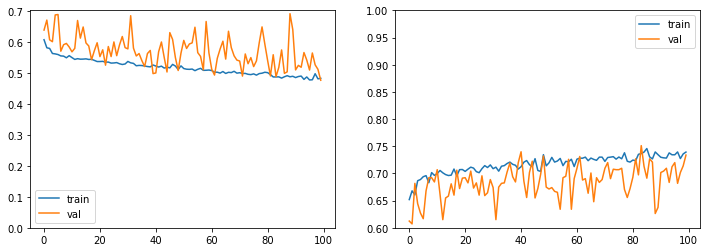

In [29]:
y = np.array([mrk.photo_reqs.mouth_open.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'mouth_open')
list_model_files.append(model_file)

#### *24. Presence of Other Faces or Toys too Close to Face*

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5170 - accuracy: 0.8291 - precision: 0.9980 - recall: 0.8280 - f1: 0.9005 - specificity: 0.1310 - negative_predictive_value: 0.0255 - matthews_correlation_coefficient: 0.0499 - val_loss: 0.4374 - val_accuracy: 0.7910 - val_precision: 1.0000 - val_recall: 0.7954 - val_f1: 0.8842 - val_specificity: 0.1892 - val_negative_predictive_value: 0.0395 - val_matthews_correlation_coefficient: 0.0769

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.07686, saving model to ../models/autoencoders_requirements/presence_of_other_faces_or_toys_2020_03_25-23_38_28.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4493 - accuracy: 0.8000 - precision: 0.9989 - recall: 0.8008 - f1: 0.8809 - specificity: 0.1586 - negative_predictive_value: 0.0273 - matthews_correlation_coefficient: 0.0522 - val_loss: 0.2281 - val_accuracy: 0.

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2105 - accuracy: 0.8610 - precision: 1.0000 - recall: 0.8609 - f1: 0.9243 - specificity: 0.1931 - negative_predictive_value: 0.0427 - matthews_correlation_coefficient: 0.0830 - val_loss: 0.2981 - val_accuracy: 0.8673 - val_precision: 1.0000 - val_recall: 0.8702 - val_f1: 0.9296 - val_specificity: 0.1892 - val_negative_predictive_value: 0.0617 - val_matthews_correlation_coefficient: 0.0999

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.10363
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2295 - accuracy: 0.8581 - precision: 0.9997 - recall: 0.8584 - f1: 0.9225 - specificity: 0.1931 - negative_predictive_value: 0.0442 - matthews_correlation_coefficient: 0.0840 - val_loss: 0.3200 - val_accuracy: 0.8682 - val_precision: 1.0000 - val_recall: 0.8710 - val_f1: 0.9301 - val_specificity: 0.1892 - val_negative_predictive_value: 0.0617 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.10637
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1747 - accuracy: 0.8831 - precision: 1.0000 - recall: 0.8831 - f1: 0.9371 - specificity: 0.2000 - negative_predictive_value: 0.0531 - matthews_correlation_coefficient: 0.0945 - val_loss: 0.2278 - val_accuracy: 0.8873 - val_precision: 1.0000 - val_recall: 0.8897 - val_f1: 0.9409 - val_specificity: 0.1892 - val_negative_predictive_value: 0.0685 - val_matthews_correlation_coefficient: 0.1064

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.10637
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1822 - accuracy: 0.8792 - precision: 1.0000 - recall: 0.8793 - f1: 0.9349 - specificity: 0.1862 - negative_predictive_value: 0.0537 - matthews_correlation_coefficient: 0.0923 - val_loss: 0.2147 - val_accuracy: 0.8846 - val_precision: 1.0000 - val_recall: 0.8871 - val_f1: 0.9394 - val_spe


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.10637
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1808 - accuracy: 0.8729 - precision: 1.0000 - recall: 0.8730 - f1: 0.9313 - specificity: 0.2069 - negative_predictive_value: 0.0543 - matthews_correlation_coefficient: 0.0986 - val_loss: 0.2053 - val_accuracy: 0.8951 - val_precision: 1.0000 - val_recall: 0.8973 - val_f1: 0.9452 - val_specificity: 0.1892 - val_negative_predictive_value: 0.0685 - val_matthews_correlation_coefficient: 0.1064

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.10637
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1696 - accuracy: 0.8950 - precision: 1.0000 - recall: 0.8950 - f1: 0.9439 - specificity: 0.1793 - negative_predictive_value: 0.0551 - matthews_correlation_coefficient: 0.0928 - val_loss: 0.2771 - val_accuracy: 0.8777 - val_precision: 1.0000 - val_recall: 0.8804 - val_f1: 0.9355 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1679 - accuracy: 0.8959 - precision: 1.0000 - recall: 0.8927 - f1: 0.9421 - specificity: 0.1931 - negative_predictive_value: 0.0585 - matthews_correlation_coefficient: 0.0995 - val_loss: 0.2703 - val_accuracy: 0.8846 - val_precision: 1.0000 - val_recall: 0.8871 - val_f1: 0.9394 - val_specificity: 0.1892 - val_negative_predictive_value: 0.0685 - val_matthews_correlation_coefficient: 0.1064

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.11459
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1672 - accuracy: 0.8998 - precision: 1.0000 - recall: 0.8998 - f1: 0.9465 - specificity: 0.2000 - negative_predictive_value: 0.0568 - matthews_correlation_coefficient: 0.0999 - val_loss: 0.2904 - val_accuracy: 0.8829 - val_precision: 1.0000 - val_recall: 0.8855 - val_f1: 0.9384 - val_specificity: 0.1892 - val_negative_predictive_value: 0.0685 - val_matthews_correlation_coefficie


Epoch 00073: val_matthews_correlation_coefficient improved from 0.11616 to 0.11841, saving model to ../models/autoencoders_requirements/presence_of_other_faces_or_toys_2020_03_25-23_38_28.h5
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1553 - accuracy: 0.9130 - precision: 0.9998 - recall: 0.9100 - f1: 0.9517 - specificity: 0.1793 - negative_predictive_value: 0.0644 - matthews_correlation_coefficient: 0.0997 - val_loss: 0.2786 - val_accuracy: 0.8803 - val_precision: 1.0000 - val_recall: 0.8829 - val_f1: 0.9369 - val_specificity: 0.1892 - val_negative_predictive_value: 0.0685 - val_matthews_correlation_coefficient: 0.1064

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.11841
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1705 - accuracy: 0.8998 - precision: 1.0000 - recall: 0.8999 - f1: 0.9466 - specificity: 0.1862 - negative_predictive_value: 0.0586 - matthews_correlation_coefficient: 0.0987 -

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1717 - accuracy: 0.9011 - precision: 1.0000 - recall: 0.9010 - f1: 0.9470 - specificity: 0.1862 - negative_predictive_value: 0.0510 - matthews_correlation_coefficient: 0.0902 - val_loss: 0.2512 - val_accuracy: 0.8968 - val_precision: 1.0000 - val_recall: 0.8991 - val_f1: 0.9461 - val_specificity: 0.1892 - val_negative_predictive_value: 0.0856 - val_matthews_correlation_coefficient: 0.1184

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.11958
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1814 - accuracy: 0.9004 - precision: 1.0000 - recall: 0.9005 - f1: 0.9468 - specificity: 0.1724 - negative_predictive_value: 0.0622 - matthews_correlation_coefficient: 0.0950 - val_loss: 0.1173 - val_accuracy: 0.9315 - val_precision: 0.9981 - val_recall: 0.9347 - val_f1: 0.9649 - val_specificity: 0.1351 - val_negative_predictive_value: 0.0946 - val_matthews_correlation_coefficie

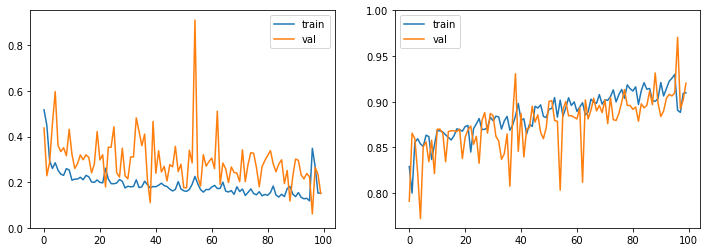

In [30]:
y = np.array([mrk.photo_reqs.presence_of_other_faces_or_toys.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'presence_of_other_faces_or_toys')
list_model_files.append(model_file)

# Models Merge

In [31]:
def add_requirement_branch_to_base_model(base_model_last_layer, req_model):
    req_layers = [layer for layer in req_model.layers if isinstance(layer, Dense)]

    outputs = base_model_last_layer
    for layer in req_layers:
        outputs = req_model.get_layer(layer.name)(outputs)

    return outputs

In [32]:
file_models = np.array([file for file in list_model_files if file is not None])

print(file_models)

['../models/autoencoders_requirements/blurred_2020_03_25-19_09_24.h5'
 '../models/autoencoders_requirements/looking_away_2020_03_25-19_24_09.h5'
 '../models/autoencoders_requirements/unnatural_skin_tone_2020_03_25-19_38_51.h5'
 '../models/autoencoders_requirements/too_dark_light_2020_03_25-19_53_30.h5'
 '../models/autoencoders_requirements/washed_out_2020_03_25-20_06_02.h5'
 '../models/autoencoders_requirements/pixelation_2020_03_25-20_15_00.h5'
 '../models/autoencoders_requirements/hair_across_eyes_2020_03_25-20_27_58.h5'
 '../models/autoencoders_requirements/eyes_closed_2020_03_25-20_35_30.h5'
 '../models/autoencoders_requirements/varied_background_2020_03_25-20_49_16.h5'
 '../models/autoencoders_requirements/roll_pitch_yaw_2020_03_25-21_04_01.h5'
 '../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_25-21_16_59.h5'
 '../models/autoencoders_requirements/red_eyes_2020_03_25-21_25_14.h5'
 '../models/autoencoders_requirements/shadows_behind_head_2020_03_25-21_37_59.h5'


In [33]:
autoencoder = load_model(FILE_BASE_MODEL)

embeddings = GlobalAvgPool2D(name='embeddings')(autoencoder.get_layer(name='encoded').output)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


In [34]:
custom_objects = {
    'recall': recall,
    'precision': precision,
    'f1': f1,
    'specificity': specificity,
    'negative_predictive_value': npv,
    'matthews_correlation_coefficient': mcc
}

list_models = [load_model(file, custom_objects=custom_objects) for file in file_models]
list_outputs = [add_requirement_branch_to_base_model(embeddings, model) for model in list_models]

In [35]:
merged_model = Model(inputs=autoencoder.inputs, outputs=list_outputs)
merged_model.summary()

merged_model.save(FILE_MERGED_MODEL)

Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 224, 224, 16) 448         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 224, 224, 16) 64          conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 224, 224, 16) 0           bn_1[0][0]                       
___________________________________________________________________________________________

In [36]:
import cv2
from glob import glob

# list_files = glob('../data/pybossa/images/*')
list_files = ['../data/pybossa/images/AR_FDB_m-013-17.png']
random_file = np.random.choice(list_files)
print(random_file)

im = load.images_from_list_files([random_file], output_size=IMAGE_SIZE, interpolation=cv2.INTER_AREA)
im /= 255

y_pred = merged_model.predict(im)
list_predictions = [model.predict(im) for model in list_models]
assert(np.all([np.allclose(pred1, pred2) for pred1, pred2 in zip(y_pred, list_predictions)]))

y_pred

../data/pybossa/images/AR_FDB_m-013-17.png
1 of 1


[array([[0.9998641]], dtype=float32),
 array([[0.65032184]], dtype=float32),
 array([[0.9963676]], dtype=float32),
 array([[0.97855264]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.90731716]], dtype=float32),
 array([[0.75141907]], dtype=float32),
 array([[0.7180842]], dtype=float32),
 array([[0.6354582]], dtype=float32),
 array([[0.82407343]], dtype=float32),
 array([[0.7437866]], dtype=float32),
 array([[0.536192]], dtype=float32),
 array([[0.9995302]], dtype=float32),
 array([[0.97561014]], dtype=float32),
 array([[0.9751409]], dtype=float32),
 array([[0.47929794]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.81463164]], dtype=float32),
 array([[0.99995875]], dtype=float32),
 array([[0.9973628]], dtype=float32),
 array([[0.49474713]], dtype=float32),
 array([[1.]], dtype=float32)]